In [58]:
import numpy as np
import pandas as pd
from io import StringIO
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchtext
from transformers import BertTokenizer, AdamW
from transformers.models.bert.modeling_bert import BertModel
import nltk
from textaugment import Wordnet
from textaugment import Translate, EDA
import albumentations as A
from nlpaug.augmenter import sentence, char
from sklearn.metrics import accuracy_score
import itertools
import optuna
from optuna.trial import TrialState, Trial
from matplotlib import pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jswietek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jswietek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jswietek\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jswietek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
augmented_train_df = pd.read_csv('../data/sentence_aug_df.csv', index_col=0)
test_df = pd.read_csv('../data/test_30.csv', index_col=0)

In [4]:
test_df

,text,HER2,ER,PR,HR,SUBTYPE
TCGA-AR-A1AR,"Final Diagnosis. Breast, left, lumpectomy: Inf...",0.0,0.0,0.0,0.0,TNBC
TCGA-E2-A14X,SPECIMENS: A. RIGHT BREAST WLE NEEDLE LOCALIZA...,0.0,0.0,0.0,0.0,TNBC
TCGA-E2-A150,SPECIMENS: A. SLN #1 LEFT AXILLA. B. SLN #2 LE...,0.0,0.0,0.0,0.0,TNBC
TCGA-A1-A0SP,UTD:01992912-611F-4A48-8570-B062CBCCAF7@. Fina...,0.0,0.0,0.0,0.0,TNBC
TCGA-A2-A0CM,Specimen #: Race: BLACK. Physician (s) : AMEND...,0.0,0.0,0.0,0.0,TNBC
...,...,...,...,...,...,...
TCGA-AR-A255,"Final Diagnosis. east, right, wide local excis...",1.0,1.0,1.0,1.0,HER2+
TCGA-BH-A0AU,FINAL DIAGNOSIS: PART 1: LEFT AXILLARY SENTINE...,1.0,1.0,1.0,1.0,HER2+
TCGA-D8-A1XJ,page 1 / 1. copy No. Examination: Histopatholo...,1.0,1.0,1.0,1.0,HER2+
TCGA-A8-A07B,Diagnosis: Poorly differentiated invasive duct...,1.0,1.0,1.0,1.0,HER2+


In [5]:
negative_df = pd.read_csv('./negative_df.csv', index_col=0)
raw_exams_df = pd.read_csv('../data/TCGA_Reports.csv')

raw_exams_df['patient_id'] = raw_exams_df['patient_filename'].apply(lambda x: x.split('.')[0])
raw_exams_df = raw_exams_df.set_index('patient_id').join(negative_df, how='inner').drop(['0'], axis=1)
raw_exams_df['SUBTYPE'] = ''

In [6]:
def get_df(path: str):
    df = pd.read_csv(path, index_col=0)
    df['patch_id'] = df['file_name'].apply(lambda x: x.split('/')[3])
    df['patient_id'] = df['patch_id'].apply(lambda x: x.split('_')[0])
    df.set_index(['patient_id', 'file_name'], inplace=True)

    return df

df = get_df('../data/TCGA_breast_patch/expression_metadata.csv')
base_df = get_df('../data/TCGA_breast_patch/metadata.csv')

expression_ids = set(df.index.levels[0]).difference(base_df.index.levels[0])

In [7]:
raw_exams_df = pd.read_csv('../data/TCGA_Reports.csv')
re_test_df = pd.read_csv('../data/re_test.csv', index_col=0)
re_test_df['pid'] = re_test_df['pid'] = ['-'.join(i.split('-')[0:3]) for i in re_test_df.index]

raw_exams_df['patient_id'] = raw_exams_df['patient_filename'].apply(lambda x: x.split('.')[0])
raw_exams_df2 = raw_exams_df.set_index('patient_id').join(re_test_df.set_index('pid'), how='inner')
raw_exams_df2['SUBTYPE'] = ''
raw_exams_df2 = raw_exams_df2[['patient_filename', 'text', 'SUBTYPE']]
raw_exams_df2

,patient_filename,text,SUBTYPE
TCGA-AC-A2FE,TCGA-AC-A2FE.F694CBD6-880D-40C7-AB17-D0AD02B7F06B,Not for Permanent Storage in Medical Records /...,
TCGA-AC-A2FM,TCGA-AC-A2FM.83BA3E82-E8E4-4A70-ADEE-A1360940EECE,ge: +. MRN #: t. the. SPECIM. Accession #. Acc...,
TCGA-AR-A0U0,TCGA-AR-A0U0.322BB8BB-100F-4838-9771-EAEE5A3B817A,"Breast, left breast, simple mastectomy: Infilt...",
TCGA-B6-A0I6,TCGA-B6-A0I6.2D3D759B-D06A-4FC6-855A-5E9F83ADBED9,Material. Submitted: !eft breast with axillary...,
TCGA-B6-A0I9,TCGA-B6-A0I9.291884D2-FDFD-4C98-BA19-1A0824ABB68F,AP Surgical Pathology: Final. CLINICAL HISTORY...,
TCGA-B6-A0IG,TCGA-B6-A0IG.4379DEE0-F7CB-4A73-8828-21EA0AA830F5,Fatient. Surgical Pathology: Final. CLINICAL H...,
TCGA-B6-A0IG,TCGA-B6-A0IG.4379DEE0-F7CB-4A73-8828-21EA0AA830F5,Fatient. Surgical Pathology: Final. CLINICAL H...,
TCGA-B6-A0IJ,TCGA-B6-A0IJ.F3BAF04C-35EE-450F-BFA8-E9DFE9F984FD,Surgical Pathology:Finels. CLINICAL HISTORY: L...,
TCGA-B6-A0IM,TCGA-B6-A0IM.4A86A028-C56D-455E-A5CD-47D8A34B5734,Putient: CLINICAL HISTORY: Not provided. GROSS...,
TCGA-B6-A0IQ,TCGA-B6-A0IQ.0ED7357E-662C-4D65-82ED-29739919068F,Patierit. CLINICAL HISTORY: Infiltrating ducta...,


In [8]:
raw_exams_df2.shape

(30, 3)

In [9]:
# no_labels_df = raw_exams_df.loc[['-'.join(i.split('-')[0:3]) for i in expression_ids]]

<AxesSubplot:>

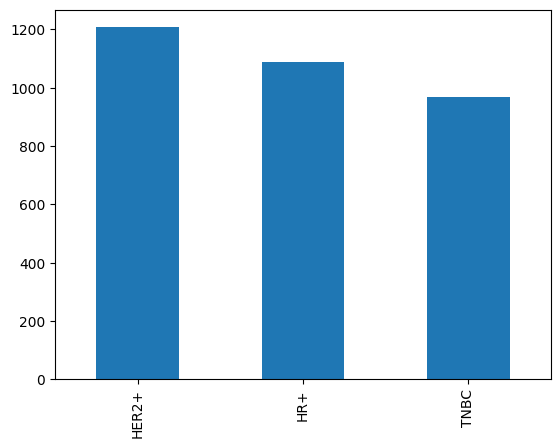

In [10]:
augmented_train_df['SUBTYPE'].value_counts().plot.bar()

<AxesSubplot:>

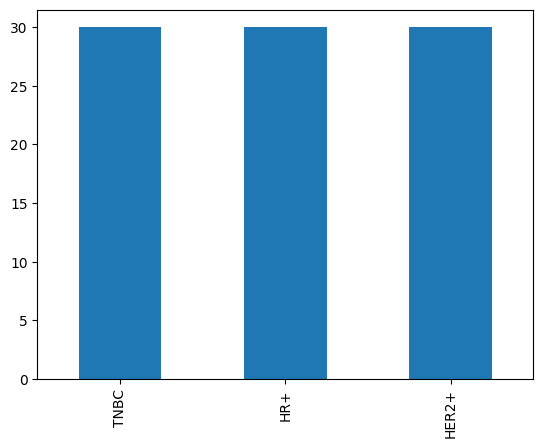

In [11]:
test_df['SUBTYPE'].value_counts().plot.bar()

In [12]:
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig, LongformerModel, AutoTokenizer, BertModel, BertTokenizer, BertConfig

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [13]:
class ExamDataset(Dataset):
    def __init__(self, df, targets, tokenizer, labels):
        self.df = df
        self.targets = targets
        self.tokenizer = tokenizer,
        self.labels = labels

    def __getitem__(self, idx):
        print(idx)
        text = self.df['text'][idx]
        print(text)
        inputs = bert_tokenizer.encode_plus(
            text if type(text) == str else text[0],
            add_special_tokens=True,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        

        return {
            'patient_id': self.df.index[idx],
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': self.labels.index(self.targets[idx]),
        }

    def __len__(self):
        return len(self.targets)

In [14]:
# labels = augmented_train_df['SUBTYPE'].value_counts().index.tolist()
labels = ['TNBC', 'HR+', 'HER2+']

In [15]:
raw_exams_df2

,patient_filename,text,SUBTYPE
TCGA-AC-A2FE,TCGA-AC-A2FE.F694CBD6-880D-40C7-AB17-D0AD02B7F06B,Not for Permanent Storage in Medical Records /...,
TCGA-AC-A2FM,TCGA-AC-A2FM.83BA3E82-E8E4-4A70-ADEE-A1360940EECE,ge: +. MRN #: t. the. SPECIM. Accession #. Acc...,
TCGA-AR-A0U0,TCGA-AR-A0U0.322BB8BB-100F-4838-9771-EAEE5A3B817A,"Breast, left breast, simple mastectomy: Infilt...",
TCGA-B6-A0I6,TCGA-B6-A0I6.2D3D759B-D06A-4FC6-855A-5E9F83ADBED9,Material. Submitted: !eft breast with axillary...,
TCGA-B6-A0I9,TCGA-B6-A0I9.291884D2-FDFD-4C98-BA19-1A0824ABB68F,AP Surgical Pathology: Final. CLINICAL HISTORY...,
TCGA-B6-A0IG,TCGA-B6-A0IG.4379DEE0-F7CB-4A73-8828-21EA0AA830F5,Fatient. Surgical Pathology: Final. CLINICAL H...,
TCGA-B6-A0IG,TCGA-B6-A0IG.4379DEE0-F7CB-4A73-8828-21EA0AA830F5,Fatient. Surgical Pathology: Final. CLINICAL H...,
TCGA-B6-A0IJ,TCGA-B6-A0IJ.F3BAF04C-35EE-450F-BFA8-E9DFE9F984FD,Surgical Pathology:Finels. CLINICAL HISTORY: L...,
TCGA-B6-A0IM,TCGA-B6-A0IM.4A86A028-C56D-455E-A5CD-47D8A34B5734,Putient: CLINICAL HISTORY: Not provided. GROSS...,
TCGA-B6-A0IQ,TCGA-B6-A0IQ.0ED7357E-662C-4D65-82ED-29739919068F,Patierit. CLINICAL HISTORY: Infiltrating ducta...,


In [36]:
train_dataset = ExamDataset(augmented_train_df, augmented_train_df['SUBTYPE'], bert_tokenizer, labels)
no_labels_dataset = ExamDataset(raw_exams_df2, raw_exams_df2['SUBTYPE'], bert_tokenizer, [''])
val_dataset = ExamDataset(test_df, test_df['SUBTYPE'], bert_tokenizer, labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
no_labels_dataloader= DataLoader(no_labels_dataset, batch_size=16)


In [17]:
class BertClassifier(nn.Module):
    def __init__(self, bert_model):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        # self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(768, 3)
    #     self.init_weights(self.linear)

    # def init_weights(self, layer: nn.Linear):
    #     layer.weight.data.uniform_(-0.5, 0.5)
    #     layer.bias.data.zero_()
        
    def forward(self, input_ids, mask, token_type_ids):
        # get last_hidden_state
        # vec, _ = self.bert(input_ids)

        bert_output = self.bert(input_ids, attention_mask = mask, token_type_ids = token_type_ids)
        # bert_output = self.bert(input_ids, attention_mask = mask)
        # only get first token 'cls'
        # print(output.keys(), output['pooler_output'].shape, output['last_hidden_state'].shape)
        # vec = vec[:,0,:]
        # vec = vec.view(-1, 768)
        # dropout_output = self.dropout(bert_output['pooler_output'])
        linear_output = self.linear(bert_output['pooler_output'])
        
        return F.softmax(linear_output, dim=1)

# classifier = BertClassifier(bert_model)

In [50]:
ckpt = torch.load('../checkpoints/bert/weighted_4_8_7.577E-06_0.249_0.138_acc_0.567_epochs_30.pt')
# ckpt = torch.load('../checkpoints/bert/weighted_69_8_7.000E-06_0.150_0.250_acc_0.478_epochs_18.pt')
bert_config = BertConfig(num_hidden_layers=4, num_attention_heads=8, attention_probs_dropout_prob=0.249, hidden_dropout_prob=0.138, vocab_size=bert_tokenizer.vocab_size)
bert_model = BertModel(bert_config)
# bert_model = BertModel.from_pretrained('bert-base-uncased')
classifier = BertClassifier(bert_model)
classifier.load_state_dict(ckpt['state_dict'])
classifier.eval()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.138, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.249, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [51]:
device = 'cpu'
classifier = classifier.to(device)
res = []
patient_ids = []
for batch in no_labels_dataloader:
    patient_ids.extend(batch['patient_id'])
    input_ids = batch['ids'].to(device)
    mask = batch['mask'].to(device, dtype = torch.long)
    token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
    targets = batch['targets'].to(device)
    outputs = classifier(input_ids, mask, token_type_ids)

    res.extend(torch.max(outputs, 1)[1].cpu().detach().numpy().tolist())

0
Not for Permanent Storage in Medical Records / Not Valid for Signing. Date of Service. Performing Facility. Result Provider. Report Name. Surgical Report. SEE REPORT. ADDENDUM INFORMATION. PROCEDURE DATE: ADDENDUM REPORT #1: COMMENT: Immunoevaluation using. Assisted Quantitative Image Analysis has been. completed and is summarized under line 10 of the diagnosis below. T: ADDENDUM REPORT #1; DIAGNOSIS: A, B/BPC & C. RIGHT BREAST, MASTECTOMY WITH SENTINEL LYMPH NODE BIOPSY AND. FOLLOW UP AXILLARY DISSECTION: 1 - 9. SEE ORIGINAL DIAGNOSIS. 10. ANCILLARY STUDIES: SEE BELOW. ASSAY RESULTS. Test. Staining Intensity. % Positive Avg. Prognostic Significance. ER. N/A. 66%. Favorable. PR. N/A. 7%. Favorable. Her2/neu. 0.4. N/A. Normal Limit. Ki-67. N/A. 11%. Borderline. REFERENCE RANGES. Test. Favorable. Borderline. Unfavorable. ER. >5%. <5%. PR. >5%. Her2/neu. <2.0. >2.0. Ki-67. <10%. >10% - <20% -. >20%. A-MALIGNANT. MD. T: (Electronic Signature). PROCEDURE DATE: SPECIMEN DESCRIPTION: A. RIG

In [41]:
patient_ids, re_test_df['pid'].to_list()

(['TCGA-AC-A2FE',
  'TCGA-AC-A2FM',
  'TCGA-AR-A0U0',
  'TCGA-B6-A0I6',
  'TCGA-B6-A0I9',
  'TCGA-B6-A0IG',
  'TCGA-B6-A0IG',
  'TCGA-B6-A0IJ',
  'TCGA-B6-A0IM',
  'TCGA-B6-A0IQ',
  'TCGA-B6-A0RG',
  'TCGA-B6-A0RH',
  'TCGA-B6-A0RI',
  'TCGA-B6-A0RM',
  'TCGA-B6-A0RS',
  'TCGA-B6-A0RT',
  'TCGA-B6-A0WX',
  'TCGA-B6-A0WX',
  'TCGA-BH-A18R',
  'TCGA-BH-A1F0',
  'TCGA-BH-A1FH',
  'TCGA-BH-A1FU',
  'TCGA-BH-A1FU',
  'TCGA-BH-A203',
  'TCGA-E9-A1RD',
  'TCGA-E9-A1RF',
  'TCGA-E9-A1RI',
  'TCGA-E9-A228',
  'TCGA-E9-A5UO',
  'TCGA-EW-A6SD'],
 ['TCGA-EW-A6SD',
  'TCGA-B6-A0IG',
  'TCGA-BH-A1FU',
  'TCGA-BH-A1FU',
  'TCGA-B6-A0I9',
  'TCGA-B6-A0IG',
  'TCGA-AC-A2FM',
  'TCGA-BH-A18R',
  'TCGA-B6-A0RH',
  'TCGA-E9-A228',
  'TCGA-AC-A2FE',
  'TCGA-B6-A0RM',
  'TCGA-E9-A5UO',
  'TCGA-E9-A1RI',
  'TCGA-B6-A0RG',
  'TCGA-B6-A0IM',
  'TCGA-E9-A1RD',
  'TCGA-B6-A0RI',
  'TCGA-E9-A1RF',
  'TCGA-BH-A1FH',
  'TCGA-AR-A0U0',
  'TCGA-BH-A203',
  'TCGA-B6-A0WX',
  'TCGA-B6-A0IJ',
  'TCGA-B6-A0RT',
  'TCGA-B

In [52]:
res_df = pd.DataFrame({'pid': patient_ids, 'predicted_subtype': [labels[s] for s in res]})

In [43]:
res_df

,pid,predicted_subtype
0,TCGA-AC-A2FE,TNBC
1,TCGA-AC-A2FM,HR+
2,TCGA-AR-A0U0,TNBC
3,TCGA-B6-A0I6,HR+
4,TCGA-B6-A0I9,TNBC
5,TCGA-B6-A0IG,HR+
6,TCGA-B6-A0IG,HR+
7,TCGA-B6-A0IJ,TNBC
8,TCGA-B6-A0IM,HR+
9,TCGA-B6-A0IQ,HR+


In [53]:
res_df = pd.merge(re_test_df, res_df, left_on='pid', right_on='pid')

In [54]:
re_test_df.drop_duplicates().shape

(27, 2)

In [48]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, accuracy_score
def get_model_stats(actual, predicted):
    global_stats = f"accuracy_{balanced_accuracy_score(actual, predicted)} precision_{precision_score(actual, predicted, average='weighted')} recall_{recall_score(actual, predicted, average='weighted')} f1_{f1_score(actual, predicted, average='weighted')}"
    local_stats = f"precision_{precision_score(actual, predicted, average=None)} recall_{recall_score(actual, predicted, average=None)} f1_{f1_score(actual, predicted, average=None)}"
    
    return global_stats, local_stats

In [55]:
accuracy_score(res_df['label'], res_df['predicted_subtype'])

0.4444444444444444

In [57]:
labels

['TNBC', 'HR+', 'HER2+']

In [59]:
get_model_stats(res_df['label'], res_df['predicted_subtype'])

('accuracy_0.46428571428571425 precision_0.6470588235294118 recall_0.4444444444444444 f1_0.4069994323825742',
 'precision_[1.         0.29411765 0.52941176] recall_[0.14285714 0.5        0.75      ] f1_[0.25       0.37037037 0.62068966]')

In [43]:
res_df = pd.DataFrame({'patient_id': patient_ids, 'labels': [labels[r] for r in res]})
res_df = res_df.drop_duplicates()
res_df
# unique_paitient_ids = res_df['patient_id'].unique()
# res_df = res_df.set_index('patient_id')

In [45]:
res_df.set_index('patient_id').to_csv('../data/text_predicted_subtypes.csv')

In [72]:
res_df.set_index('patient_id')

,labels
patient_id,
TCGA-B6-A0RQ,TNBC
TCGA-E9-A5UO,TNBC
TCGA-B6-A0WX,TNBC
TCGA-BH-A1FU,HR+
TCGA-5L-AAT1,HR+
...,...
TCGA-E9-A1RC,HR+
TCGA-BH-A8FZ,HR+
TCGA-E9-A2JS,HER2+


<AxesSubplot:>

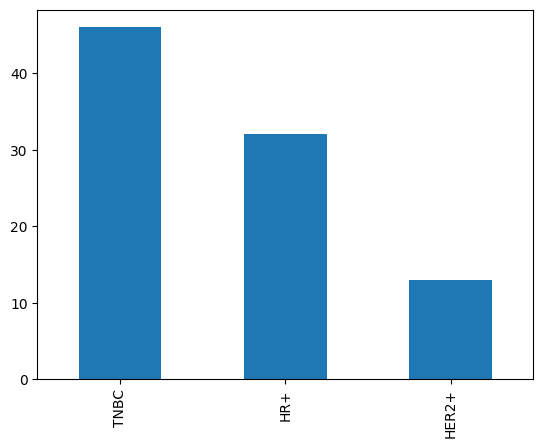

In [46]:
res_df['labels'].value_counts().plot(kind='bar')

In [48]:
df['pid'] = ['-'.join(i.split('-')[0:3]) for i in df.index.get_level_values(0)]

In [59]:
aug_data = pd.read_csv('../data/img_augmented_train_df_expr.csv', index_col=0)
aug_data['pid'] = ['-'.join(i.split('-')[0:3]) for i in aug_data.index.get_level_values(0)]
aug_data

,file_name,label,patch_id,transform,pid
patient_id,,,,,
TCGA-3C-AALI-01A-01-T,../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-...,HER2+,TCGA-3C-AALI-01A-01-T_R1,none,TCGA-3C-AALI
TCGA-3C-AALI-01A-01-T,../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-...,HER2+,TCGA-3C-AALI-01A-01-T_R1,none,TCGA-3C-AALI
TCGA-3C-AALI-01A-01-T,../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-...,HER2+,TCGA-3C-AALI-01A-01-T_R1,none,TCGA-3C-AALI
TCGA-3C-AALI-01A-01-T,../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-...,HER2+,TCGA-3C-AALI-01A-01-T_R1,none,TCGA-3C-AALI
TCGA-3C-AALI-01A-01-T,../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-...,HER2+,TCGA-3C-AALI-01A-01-T_R1,none,TCGA-3C-AALI
...,...,...,...,...,...
TCGA-PL-A8LZ-01A-03-Dv3,../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-...,TNBC,TCGA-PL-A8LZ-01A-03-D_R2,flip,TCGA-PL-A8LZ
TCGA-PL-A8LZ-01A-03-Dv3,../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-...,TNBC,TCGA-PL-A8LZ-01A-03-D_R2,flip,TCGA-PL-A8LZ
TCGA-PL-A8LZ-01A-03-Dv3,../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-...,TNBC,TCGA-PL-A8LZ-01A-03-D_R2,flip,TCGA-PL-A8LZ


In [70]:
aug_data['full_patient_id'] = aug_data.index.get_level_values(0)
text_labeled_df = pd.merge(aug_data, res_df, how='left', right_on='patient_id', left_on='pid')
text_labeled_df['a'] = text_labeled_df.apply(lambda x: x['labels'] if x['labels'] == np.nan else x['label'], axis=1)
text_labeled_df['label'] = text_labeled_df['a']
text_labeled_df

,file_name,label,patch_id,transform,pid,full_patient_id,patient_id,labels,a
0,../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-...,HER2+,TCGA-3C-AALI-01A-01-T_R1,none,TCGA-3C-AALI,TCGA-3C-AALI-01A-01-T,NaN,NaN,HER2+
1,../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-...,HER2+,TCGA-3C-AALI-01A-01-T_R1,none,TCGA-3C-AALI,TCGA-3C-AALI-01A-01-T,NaN,NaN,HER2+
2,../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-...,HER2+,TCGA-3C-AALI-01A-01-T_R1,none,TCGA-3C-AALI,TCGA-3C-AALI-01A-01-T,NaN,NaN,HER2+
3,../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-...,HER2+,TCGA-3C-AALI-01A-01-T_R1,none,TCGA-3C-AALI,TCGA-3C-AALI-01A-01-T,NaN,NaN,HER2+
4,../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-...,HER2+,TCGA-3C-AALI-01A-01-T_R1,none,TCGA-3C-AALI,TCGA-3C-AALI-01A-01-T,NaN,NaN,HER2+
...,...,...,...,...,...,...,...,...,...
1119547,../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-...,TNBC,TCGA-PL-A8LZ-01A-03-D_R2,flip,TCGA-PL-A8LZ,TCGA-PL-A8LZ-01A-03-Dv3,TCGA-PL-A8LZ,TNBC,TNBC
1119548,../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-...,TNBC,TCGA-PL-A8LZ-01A-03-D_R2,flip,TCGA-PL-A8LZ,TCGA-PL-A8LZ-01A-03-Dv3,TCGA-PL-A8LZ,TNBC,TNBC
1119549,../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-...,TNBC,TCGA-PL-A8LZ-01A-03-D_R2,flip,TCGA-PL-A8LZ,TCGA-PL-A8LZ-01A-03-Dv3,TCGA-PL-A8LZ,TNBC,TNBC
1119550,../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-...,TNBC,TCGA-PL-A8LZ-01A-03-D_R2,flip,TCGA-PL-A8LZ,TCGA-PL-A8LZ-01A-03-Dv3,TCGA-PL-A8LZ,TNBC,TNBC


In [66]:
df

label  \
patient_id            file_name                                                   
TCGA-3C-AALI-01A-01-T ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  HER2+   
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  HER2+   
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  HER2+   
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  HER2+   
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  HER2+   
...                                                                         ...   
TCGA-PL-A8LZ-01A-03-D ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...   TNBC   
                      ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...   TNBC   
                      ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...   TNBC   
                      ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...   TNBC   
                      ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...   TNBC   

                                                                                          patch_id  \
patient_id            file_name                                                                      
TCGA-3C-AALI-01A-01-T ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI-01A-01-T_R1   
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI-01A-01-T_R1   
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI-01A-01-T_R1   
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI-01A-01-T_R1   
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI-01A-01-T_R1   
...                                                                                            ...   
TCGA-PL-A8LZ-01A-03-D ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...  TCGA-PL-A8LZ-01A-03-D_R2   
                      ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...  TCGA-PL-A8LZ-01A-03-D_R2   
                      ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...  TCGA-PL-A8LZ-01A-03-D_R2   
                      ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...  TCGA-PL-A8LZ-01A-03-D_R2   
                      ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...  TCGA-PL-A8LZ-01A-03-D_R2   

                                                                                   pid  
patient_id            file_name                                                         
TCGA-3C-AALI-01A-01-T ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI  
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI  
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI  
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI  
                      ../data/TCGA_breast_patch/TCGA-3C-AALI-01A-01-T...  TCGA-3C-AALI  
...                                                                                ...  
TCGA-PL-A8LZ-01A-03-D ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...  TCGA-PL-A8LZ  
                      ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...  TCGA-PL-A8LZ  
                      ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...  TCGA-PL-A8LZ  
                      ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...  TCGA-PL-A8LZ  
                      ../data/TCGA_breast_patch/TCGA-PL-A8LZ-01A-03-D...  TCGA-PL-A8LZ  

[776575 rows x 3 columns]

In [11]:
import shutil, sys   
def save_ckp(state, title):
    """
    state: checkpoint we want to save
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    is_best: is this the best checkpoint; min validation loss
    """
    f_path = f"../checkpoints/bert/{title}.pt"
    torch.save(state, f_path)

In [12]:
def plot_training_stats(train_losses, valid_losses, valid_accuracies, title):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    fig.suptitle(title, fontsize=20)
    axs[0].plot(train_losses)
    axs[0].title.set_text('train losses')
    axs[1].plot(valid_losses)
    axs[1].title.set_text('valid losses')
    axs[2].plot(valid_accuracies)
    axs[2].title.set_text('valid accuracies')

    fig.savefig(f'../plots/text/{title}.png')

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def map_output_to_labels(arr: list, labels):
    # return [labels[el.index(1.0)] for el in arr]
    return [labels[el] for el in arr]

def plot_confusion_matrix(actual, predicted, title, labels):
    fig, ax = plt.subplots()
    fig.suptitle(title, fontsize=20)
    
    # cm = confusion_matrix(map_output_to_labels(actual, labels), map_output_to_labels(predicted, labels), labels=labels)
    cm = confusion_matrix(actual, predicted, labels=labels)
    # sns.heatmap(cm, yticklabels=labels, xticklabels=labels)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax)
    new_title = title.replace('_', '__').replace('.', '_')
    fig.savefig(f'../plots/text/{new_title}__corr.png')

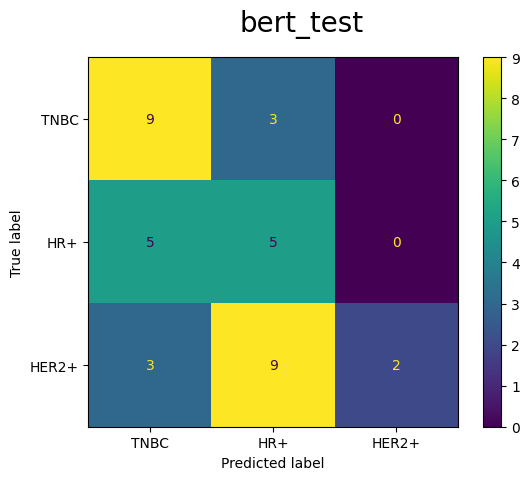

In [66]:
plot_confusion_matrix(res_df['label'].to_list(), res_df['predicted_subtype'].to_list(), 'bert_test', labels)

In [14]:
actual = ['TNBC'] * 30 + ['HR+'] * 30 + ['HER2+'] * 30
predicted = ['TNBC'] * 28 + ['HR+'] * 43 + ['HER2+'] * 19
accuracy_score(actual, predicted)
# plot_confusion_matrix([0, 2, 1], [0, 2, 2], 'test', labels)

0.8555555555555555

In [16]:
import gc
max_study_accuracy = 0

def train_model(trial: Trial=None, params: dict = None):
    #Hyperparameters
    if trial:
        max_epochs = 30
        early_stop_thresh = 10
        num_hidden_layers = trial.suggest_int("num_hidden_layers", 4, 8, step=2)
        num_attention_heads = trial.suggest_int("num_attention_heads", 4, 8, step=2)
        lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
        hidden_dropout_prob = trial.suggest_float("hidden_dropout_prob", 0.1, 0.5)
        attention_probs_dropout_prob = trial.suggest_float("attention_probs_dropout_prob", 0.1, 0.5)
    if params:
        max_epochs = params['max_epochs']
        early_stop_thresh = params['max_epochs']
        num_hidden_layers = params['num_hidden_layers']
        num_attention_heads = params['num_attention_heads']
        lr = params['lr']
        hidden_dropout_prob = params['hidden_dropout_prob']
        attention_probs_dropout_prob = params['attention_probs_dropout_prob']
    global max_study_accuracy

    print('num_hidden_layers: {:d}; num_attention_heads: {:d}; lr{:.3E}; attention_probs_dropout_prob: {:.3f}; hidden_dropout_prob: {:.3f}'.format(num_hidden_layers, num_attention_heads, lr, attention_probs_dropout_prob, hidden_dropout_prob))
    # device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    device = torch.device('cpu')
    #Datasets
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
    
    #Model
    bert_config = BertConfig(num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads, attention_probs_dropout_prob=attention_probs_dropout_prob, hidden_dropout_prob=hidden_dropout_prob, vocab_size=bert_tokenizer.vocab_size)
    bert_model = BertModel.from_pretrained("bert-base-uncased")
    classifier = BertClassifier(bert_model)

    classifier.to(device)

    weight = torch.Tensor((augmented_train_df.shape[0] / (augmented_train_df['SUBTYPE'].value_counts() * len(labels))).to_numpy()).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(weight)

    optim = AdamW(classifier.parameters(), lr=lr) #przetestowa inne

    best_epoch = 0
    train_losses = []
    valid_losses = []
    valid_accuracy = []
    valid_loss_min = np.Inf

    
    epoch = 0
    while epoch < max_epochs:
        print(f"Epoch no. {epoch} started")
        classifier.train()
        train_loss = 0
        valid_loss = 0
        for batch_id, batch in enumerate(train_loader):
            input_ids = batch['ids'].to(device)
            mask = batch['mask'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device)
            outputs = classifier(input_ids, mask, token_type_ids)

            optim.zero_grad()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optim.step()
            # train_loss = train_loss + ((1 / (batch_id + 1)) * (loss.item() - train_loss))
            train_loss += loss.item()
        avg_train_loss = train_loss/len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_targets=[]
        val_outputs=[]
        classifier.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(val_loader):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device)
                outputs = classifier(ids, mask, token_type_ids)
                loss = loss_fn(outputs, targets)
                # valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
                valid_loss += loss.item()
                val_targets.extend(targets.cpu().detach().numpy().tolist())
                val_outputs.extend(torch.max(outputs, 1)[1].cpu().detach().numpy().tolist())
        avg_valid_loss = valid_loss/len(val_loader)
        valid_losses.append(avg_valid_loss)
        # calculate average losses

        # print training/validation statistics 
        accuracy = accuracy_score(val_targets, val_outputs)
        
        
        # create checkpoint variable and add important data
        
        if len(valid_accuracy) == 0 or accuracy > max(valid_accuracy):
            print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}\tValidation accuracy: {:.6f}'.format(
                epoch, 
                avg_train_loss,
                avg_valid_loss,
                accuracy
                ))
            best_epoch = epoch
        elif epoch - best_epoch > early_stop_thresh:
            print(f"Early stopped training at epoch {epoch}")
            break

        if accuracy > max_study_accuracy:
            best_study_title = 'weighted_{:d}_{:d}_{:.3E}_{:.3f}_{:.3f}_acc_{:.3f}_epochs_{:d}'.format(num_hidden_layers, num_attention_heads, lr, attention_probs_dropout_prob, hidden_dropout_prob,accuracy, len(valid_losses))
            plot_confusion_matrix(val_targets, val_outputs, best_study_title, labels)
            checkpoint = {
                'epoch': epoch + 1,
                'valid_loss_min': avg_valid_loss,
                'valid_accuracy': accuracy,
                'state_dict': classifier.state_dict(),
                'optimizer': optim.state_dict()
            }
            save_ckp(checkpoint, best_study_title)
            max_study_accuracy = accuracy

        valid_accuracy.append(accuracy)
        epoch += 1
    title = 'weighted_{:d}_{:d}_{:.3E}_{:.3f}_{:.3f}_acc_{:.3f}_epochs: {:d}'.format(num_hidden_layers, num_attention_heads, lr, attention_probs_dropout_prob, hidden_dropout_prob, max(valid_accuracy), len(valid_losses))
    plot_training_stats(train_losses, valid_losses, valid_accuracy, title)
    print(title)
    
    del classifier
    del bert_model
    torch.cuda.empty_cache()
    gc.collect()

    return max(valid_accuracy)

# study = optuna.create_study(direction="maximize")
# study.optimize(train_model, n_trials=100, gc_after_trial=True)

num_hidden_layers: 69; num_attention_heads: 4; lr3.438E-06; attention_probs_dropout_prob: 0.158; hidden_dropout_prob: 0.217
Epoch no. 0 started
Epoch: 0 	Avgerage Training Loss: 1.065474 	Average Validation Loss: 1.060444	Validation accuracy: 0.444444
Epoch no. 1 started


KeyboardInterrupt: 

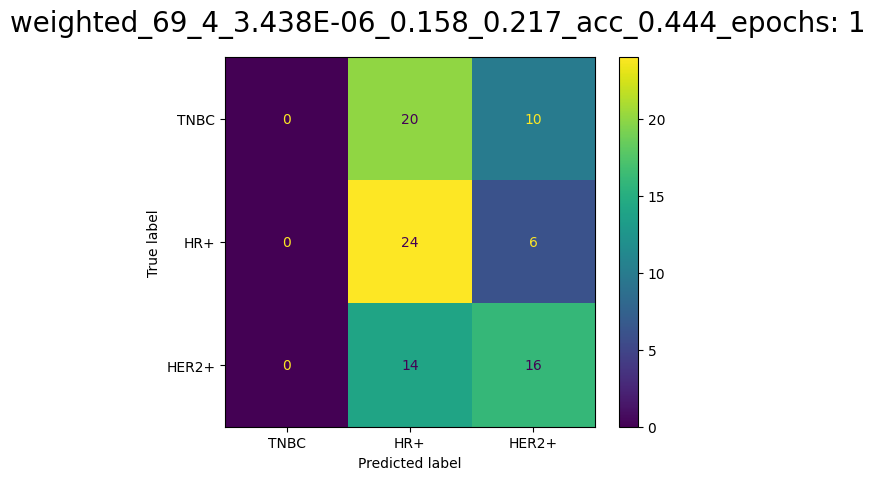

In [18]:
# for it in range(100):
train_model(params={
    'max_epochs': 10,
    'num_hidden_layers': 69,
    'num_attention_heads': 4,
    'lr': 3.438e-6,
    'hidden_dropout_prob': 0.217,
    'attention_probs_dropout_prob': 0.158,
})

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(train_model, n_trials=100, gc_after_trial=True)

[I 2024-03-21 10:42:55,609] A new study created in memory with name: no-name-1fddb47f-4e00-46fd-8dc9-75d4045e8eaa


num_hidden_layers: 8; num_attention_heads: 6; lr1.346E-06; attention_probs_dropout_prob: 0.497; hidden_dropout_prob: 0.223


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[W 2024-03-21 10:42:57,550] Trial 0 failed with parameters: {'num_hidden_layers': 8, 'num_attention_heads': 6, 'lr': 1.3455575036571317e-06, 'hidden_dropout_prob': 0.22344723028106733, 'attention_probs_dropout_prob': 0.496917974793355} because of the following error: RuntimeError('unique_by_key: failed to synchronize: cudaErrorAssert: device-side assert triggered').
Traceback (most recent call last):
  File "d:\jswietek\mgr\env\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\jswietek\AppData\Local\Temp\2\ipykernel_15672\1146907207.py", line 62, in train_model
    loss.backward()
  File "d:\jswietek\mgr\env\lib\si

RuntimeError: unique_by_key: failed to synchronize: cudaErrorAssert: device-side assert triggered

num_hidden_layers: 4; num_attention_heads: 6; lr9.202E-06; attention_probs_dropout_prob: 0.207; hidden_dropout_prob: 0.183


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.086804 	Average Validation Loss: 1.092372	Validation accuracy: 0.333333
Validation loss decreased (inf --> 6.554233).  Saving model ...
############# Epoch 0  Done   #############

############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.078427 	Average Validation Loss: 1.060469	Validation accuracy: 0.477778
Validation loss decreased (6.554233 --> 6.362814).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 13: Validation End     #############
Epoch: 13 	Avgerage Training Loss: 0.695279 	Average Validation Loss: 1.013751	Validation accuracy: 0.533333
Validation loss decreased (6.362814 --> 6.082505).  Saving model ...
############# Epoch 13  Done   #############

############# Epoch 14: Validation End     #############
Epoch: 14 	Avgerage Training Loss: 0.678755 	Average Validation Loss: 0.994934	Validation accuracy: 0.544444
Va

0.5777777777777777

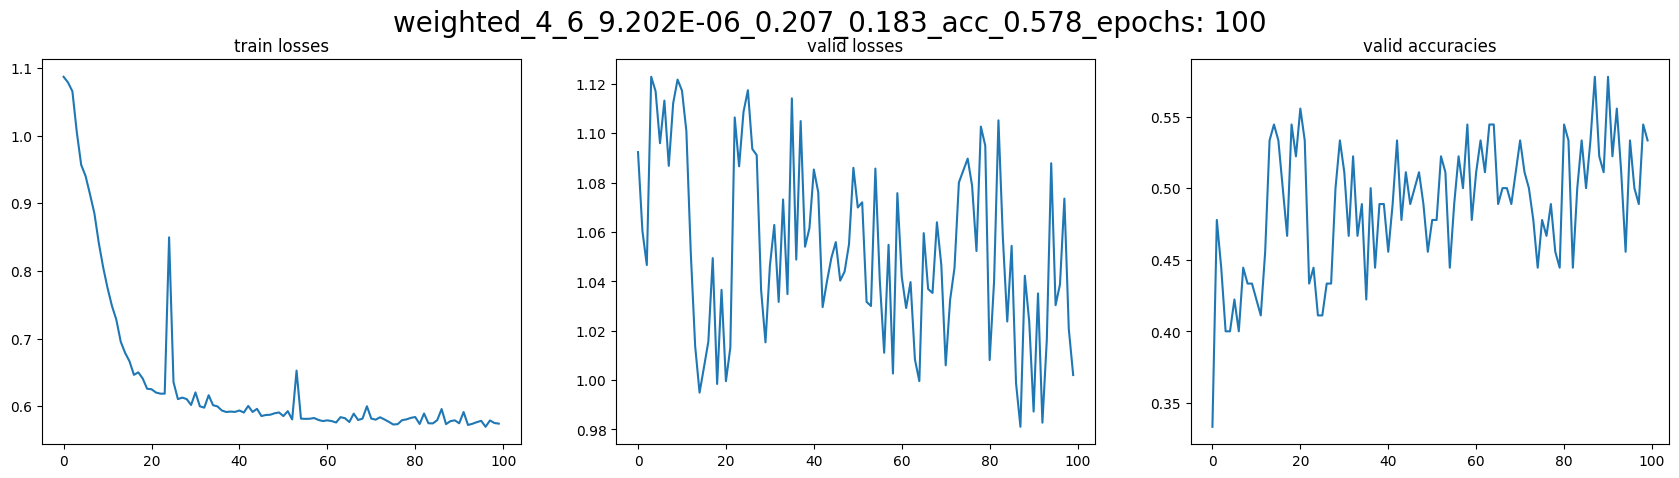

In [ ]:
train_params = study.best_params
train_params['max_epochs'] = 100
train_model(params=train_params)

num_hidden_layers: 4; num_attention_heads: 6; lr9.202E-06; attention_probs_dropout_prob: 0.207; hidden_dropout_prob: 0.183


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.084319 	Average Validation Loss: 1.087042	Validation accuracy: 0.333333
Validation loss decreased (inf --> 6.522250).  Saving model ...
############# Epoch 0  Done   #############

############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.079426 	Average Validation Loss: 1.065178	Validation accuracy: 0.422222
Validation loss decreased (6.522250 --> 6.391070).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.057790 	Average Validation Loss: 1.049718	Validation accuracy: 0.444444
Validation loss decreased (6.391070 --> 6.298305).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 9: Validation End     #############
Epoch: 9 	Avgerage Training Loss: 0.803510 	Average Validation Loss: 1.067852	Validation accuracy: 0.455556
Validat

0.5666666666666667

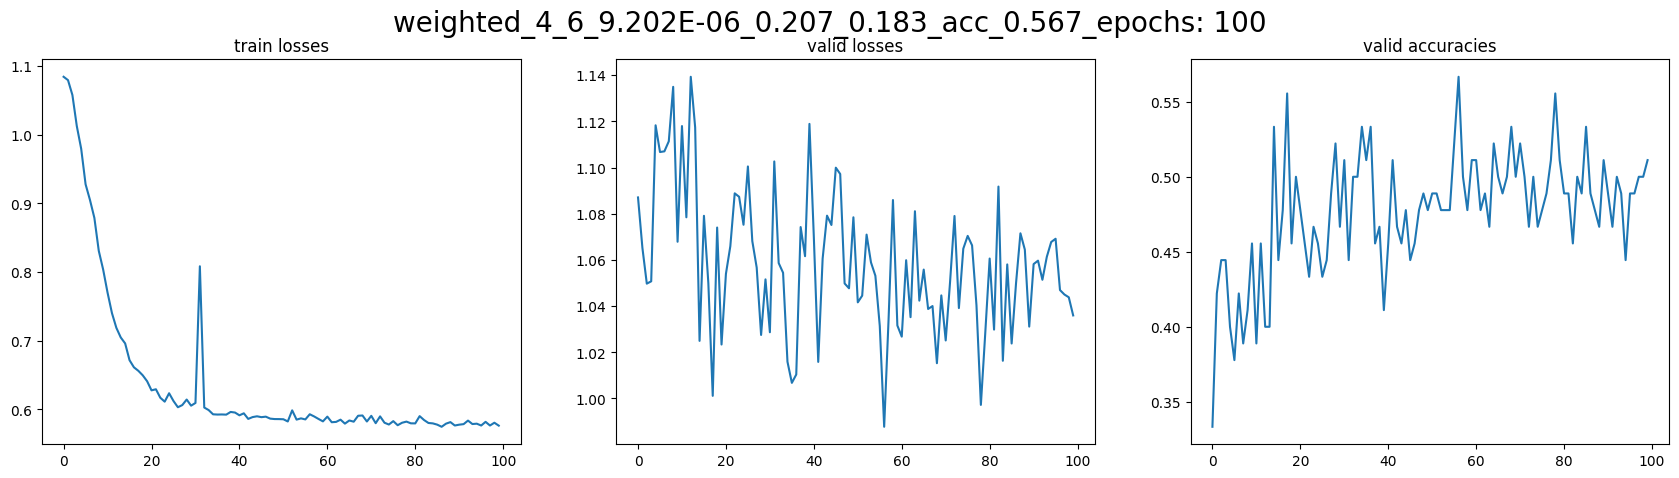

In [ ]:
train_params = study.best_params
train_params['max_epochs'] = 100
train_model(params=train_params)

In [ ]:
# lr_options = [1e-2, 1e-3, 1e-4, 1e-5]
# num_hidden_layers_options = [1, 2, 4, 6, 8]
# num_attention_heads_options = [1, 2, 4, 6, 8]
# options_combinantions = list(itertools.product(lr_options, num_hidden_layers_options, num_attention_heads_options))

# valid_accuracy_history = []
# valid_losses_history = []
# train_losses_history = []

# for lr, num_hidden_layers, num_attention_heads in options_combinantions:
#     print(f"Started testing following params: lr: {lr}, num_hidden_layers: {num_hidden_layers}, num_attention_heads: {num_attention_heads}")
#     valid_accuracy, valid_losses, train_losses = train_model(lr, num_hidden_layers, num_attention_heads)
#     print(f"Best accuracy: {max(valid_accuracy)}")
    
#     valid_accuracy_history.append(valid_accuracy)
#     valid_losses_history.append(valid_losses)
#     train_losses_history.append(train_losses)

Started testing following params: lr: 0.01, num_hidden_layers: 1, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


466.69085770845413
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.303606 	Average Validation Loss: 1.270311	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.1162863969803
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.321554 	Average Validation Loss: 1.274450	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.0007104873657
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.321231 	Average Validation Loss: 1.259310	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


472.95959067344666
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.321116 	Average Validation Loss: 1.254743	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


472.9497818350792
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.321089 	Average Validation Loss: 1.265148	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.04037219285965
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.321342 	Average Validation Loss: 1.275519	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.2115743756294
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.321820 	Average Validation Loss: 1.259119	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 1, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.2592611312866
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.151562 	Average Validation Loss: 1.143612	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.49974727630615
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152234 	Average Validation Loss: 1.163228	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.58133578300476
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152462 	Average Validation Loss: 1.167009	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.56204891204834
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152408 	Average Validation Loss: 1.162322	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.38681304454803
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.151918 	Average Validation Loss: 1.155519	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.62624019384384
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152587 	Average Validation Loss: 1.155505	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7433341741562
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152914 	Average Validation Loss: 1.147663	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 1, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.9729698896408
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.153556 	Average Validation Loss: 1.150047	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.75466644763947
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152946 	Average Validation Loss: 1.145131	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.64602422714233
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152643 	Average Validation Loss: 1.154458	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.87334644794464
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.153278 	Average Validation Loss: 1.158982	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.37723755836487
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.151892 	Average Validation Loss: 1.144592	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7778260111809
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.153011 	Average Validation Loss: 1.152348	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5002402663231
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152235 	Average Validation Loss: 1.158548	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 1, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


472.35127502679825
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.319417 	Average Validation Loss: 1.261946	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.0105119943619
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.321258 	Average Validation Loss: 1.269658	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.0994246006012
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.321507 	Average Validation Loss: 1.268836	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.05566799640656
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.321385 	Average Validation Loss: 1.248612	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.1202108860016
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.321565 	Average Validation Loss: 1.259803	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


472.9993337392807
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.321227 	Average Validation Loss: 1.256656	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.14652717113495
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.321638 	Average Validation Loss: 1.259693	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 1, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7879908680916
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.153039 	Average Validation Loss: 1.159450	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6237453818321
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152580 	Average Validation Loss: 1.157099	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4348209500313
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152053 	Average Validation Loss: 1.167377	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.446407020092
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152085 	Average Validation Loss: 1.160060	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6482231616974
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152649 	Average Validation Loss: 1.157353	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.53103494644165
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152321 	Average Validation Loss: 1.151503	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.3928788304329
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.151935 	Average Validation Loss: 1.177599	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 2, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


417.34860014915466
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.165778 	Average Validation Loss: 1.233646	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6741224527359
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180654 	Average Validation Loss: 1.216880	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5473201870918
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180300 	Average Validation Loss: 1.229610	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5999881029129
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180447 	Average Validation Loss: 1.227182	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.67017632722855
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180643 	Average Validation Loss: 1.216278	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.72532308101654
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180797 	Average Validation Loss: 1.223808	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5621363520622
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.180341 	Average Validation Loss: 1.230113	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 2, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.4786533713341
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.180108 	Average Validation Loss: 1.235139	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.43295127153397
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.179980 	Average Validation Loss: 1.226366	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6953850388527
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180713 	Average Validation Loss: 1.222366	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.61910331249237
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180500 	Average Validation Loss: 1.230806	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.59071880578995
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180421 	Average Validation Loss: 1.241870	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.7023051381111
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180733 	Average Validation Loss: 1.227039	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.3943662047386
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.179873 	Average Validation Loss: 1.242994	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 2, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7273067831993
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.152870 	Average Validation Loss: 1.160129	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6510381102562
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152657 	Average Validation Loss: 1.153718	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5301995873451
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152319 	Average Validation Loss: 1.152289	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.60231494903564
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152520 	Average Validation Loss: 1.167511	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.43294924497604
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152047 	Average Validation Loss: 1.146276	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.3991838693619
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.151953 	Average Validation Loss: 1.144585	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7552285194397
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152948 	Average Validation Loss: 1.168108	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 2, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


413.15771609544754
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.154072 	Average Validation Loss: 1.147969	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.71122562885284
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152825 	Average Validation Loss: 1.153685	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.8038364648819
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.153083 	Average Validation Loss: 1.148281	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4865937232971
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152197 	Average Validation Loss: 1.152454	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7501729130745
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152933 	Average Validation Loss: 1.149143	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6156998872757
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152558 	Average Validation Loss: 1.143886	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.60202395915985
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152520 	Average Validation Loss: 1.156076	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 2, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.18214762210846
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.321738 	Average Validation Loss: 1.264317	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.0779801607132
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.321447 	Average Validation Loss: 1.280122	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.043270945549
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.321350 	Average Validation Loss: 1.269159	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.0967427492142
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.321499 	Average Validation Loss: 1.260939	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.04109239578247
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.321344 	Average Validation Loss: 1.276358	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.15499234199524
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.321662 	Average Validation Loss: 1.259795	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.1946558356285
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.321773 	Average Validation Loss: 1.274859	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 4, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.8265962600708
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.181080 	Average Validation Loss: 1.220579	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6517260670662
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180591 	Average Validation Loss: 1.236333	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.59772169589996
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180441 	Average Validation Loss: 1.221799	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6740849018097
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180654 	Average Validation Loss: 1.228350	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6208999156952
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180505 	Average Validation Loss: 1.225991	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.583155810833
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180400 	Average Validation Loss: 1.239639	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.72984743118286
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.180810 	Average Validation Loss: 1.236094	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 4, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.2575880289078
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.151558 	Average Validation Loss: 1.148947	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5577926039696
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152396 	Average Validation Loss: 1.168173	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.57217448949814
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152436 	Average Validation Loss: 1.147067	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5379215478897
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152341 	Average Validation Loss: 1.148585	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6202846169472
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152571 	Average Validation Loss: 1.152845	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.67733055353165
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152730 	Average Validation Loss: 1.148947	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.60632103681564
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152532 	Average Validation Loss: 1.151491	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 4, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.520454287529
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.152292 	Average Validation Loss: 1.152845	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.350399017334
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.151817 	Average Validation Loss: 1.158729	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5787019133568
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152454 	Average Validation Loss: 1.178785	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4707571864128
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152153 	Average Validation Loss: 1.156787	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.61789524555206
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152564 	Average Validation Loss: 1.168168	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.55869257450104
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152399 	Average Validation Loss: 1.164337	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4722853899002
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152157 	Average Validation Loss: 1.166248	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 4, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.1870649456978
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.321752 	Average Validation Loss: 1.274586	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.18492114543915
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.321746 	Average Validation Loss: 1.274689	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.13977909088135
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.321619 	Average Validation Loss: 1.264332	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.00867623090744
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.321253 	Average Validation Loss: 1.259836	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.07552552223206
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.321440 	Average Validation Loss: 1.263713	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.17017209529877
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.321704 	Average Validation Loss: 1.277716	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


472.9348279237747
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.321047 	Average Validation Loss: 1.273934	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 4, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


415.58008176088333
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.160838 	Average Validation Loss: 1.166378	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5176755785942
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152284 	Average Validation Loss: 1.159847	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.47127240896225
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152154 	Average Validation Loss: 1.147527	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.8275409936905
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.153150 	Average Validation Loss: 1.153535	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.62750321626663
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152591 	Average Validation Loss: 1.158717	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.61726105213165
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152562 	Average Validation Loss: 1.170340	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.48915845155716
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152204 	Average Validation Loss: 1.161426	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 6, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.8132948279381
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.153110 	Average Validation Loss: 1.138714	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6101826429367
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152542 	Average Validation Loss: 1.157711	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6573950648308
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152674 	Average Validation Loss: 1.167218	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7348799109459
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152891 	Average Validation Loss: 1.167362	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.79790967702866
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.153067 	Average Validation Loss: 1.157874	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.56863808631897
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152426 	Average Validation Loss: 1.148114	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.81722831726074
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.153121 	Average Validation Loss: 1.150286	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 6, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.4956279397011
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.180155 	Average Validation Loss: 1.235045	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.63899052143097
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180556 	Average Validation Loss: 1.220095	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6324574947357
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180538 	Average Validation Loss: 1.235627	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.7345892190933
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180823 	Average Validation Loss: 1.230668	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.50356179475784
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180178 	Average Validation Loss: 1.231439	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.66853672266006
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180638 	Average Validation Loss: 1.231583	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.42124688625336
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.179948 	Average Validation Loss: 1.230019	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 6, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


462.67713499069214
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.292394 	Average Validation Loss: 1.277727	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.11682015657425
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.321555 	Average Validation Loss: 1.266810	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.0449252128601
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.321355 	Average Validation Loss: 1.263859	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.0791239142418
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.321450 	Average Validation Loss: 1.274119	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.1283041238785
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.321587 	Average Validation Loss: 1.251024	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.0830948352814
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.321461 	Average Validation Loss: 1.261584	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


472.9752870798111
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.321160 	Average Validation Loss: 1.274066	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 6, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


413.03441148996353
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.153727 	Average Validation Loss: 1.151912	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.528067111969
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152313 	Average Validation Loss: 1.189803	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.72475761175156
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152862 	Average Validation Loss: 1.154842	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7124566435814
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152828 	Average Validation Loss: 1.152713	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.8112719655037
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.153104 	Average Validation Loss: 1.160401	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5862332582474
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152476 	Average Validation Loss: 1.148166	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7119492292404
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152827 	Average Validation Loss: 1.147723	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 6, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


413.1804599761963
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.154135 	Average Validation Loss: 1.152635	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.40296787023544
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.151964 	Average Validation Loss: 1.148281	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5809878706932
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152461 	Average Validation Loss: 1.149941	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7422266602516
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152911 	Average Validation Loss: 1.148154	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.791216135025
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.153048 	Average Validation Loss: 1.161555	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.57577419281006
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152446 	Average Validation Loss: 1.152922	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6274266242981
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152591 	Average Validation Loss: 1.150532	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 8, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6655707359314
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.180630 	Average Validation Loss: 1.247696	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.7543375492096
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180878 	Average Validation Loss: 1.224717	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6016591787338
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180452 	Average Validation Loss: 1.234726	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.48459792137146
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180125 	Average Validation Loss: 1.223879	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.72078561782837
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180784 	Average Validation Loss: 1.234051	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.50866132974625
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180192 	Average Validation Loss: 1.240677	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.59572899341583
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.180435 	Average Validation Loss: 1.230881	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 8, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5447872877121
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.152360 	Average Validation Loss: 1.156422	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5149122476578
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152276 	Average Validation Loss: 1.161305	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.509646654129
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152262 	Average Validation Loss: 1.155015	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5689968466759
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152427 	Average Validation Loss: 1.167902	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.621358692646
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152574 	Average Validation Loss: 1.156349	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.54859405755997
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152370 	Average Validation Loss: 1.162733	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6651033759117
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152696 	Average Validation Loss: 1.154239	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 8, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


413.7573166489601
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.155747 	Average Validation Loss: 1.153139	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7531227469444
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152942 	Average Validation Loss: 1.146552	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7914505004883
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.153049 	Average Validation Loss: 1.139983	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6066527366638
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152533 	Average Validation Loss: 1.142423	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5804842710495
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152459 	Average Validation Loss: 1.153820	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.58767980337143
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152480 	Average Validation Loss: 1.153219	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7352710366249
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152892 	Average Validation Loss: 1.154859	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 8, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.60010755062103
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.152514 	Average Validation Loss: 1.139857	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6028410792351
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152522 	Average Validation Loss: 1.159363	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.44959765672684
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152094 	Average Validation Loss: 1.158214	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.77160304784775
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152993 	Average Validation Loss: 1.148502	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5666897892952
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152421 	Average Validation Loss: 1.159686	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4512901902199
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152099 	Average Validation Loss: 1.152482	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.586882352829
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152477 	Average Validation Loss: 1.152640	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.01, num_hidden_layers: 8, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.75872707366943
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.152957 	Average Validation Loss: 1.148804	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.55472511053085
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152388 	Average Validation Loss: 1.176069	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.49011766910553
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152207 	Average Validation Loss: 1.144030	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.37156504392624
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.151876 	Average Validation Loss: 1.158988	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.37777614593506
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.151893 	Average Validation Loss: 1.157345	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.48073613643646
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152181 	Average Validation Loss: 1.159221	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5148189663887
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152276 	Average Validation Loss: 1.150185	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 1, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


424.03323233127594
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.184450 	Average Validation Loss: 1.235438	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.60732305049896
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180467 	Average Validation Loss: 1.236744	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.4887217283249
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180136 	Average Validation Loss: 1.230379	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6681597828865
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180637 	Average Validation Loss: 1.231003	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.56028485298157
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180336 	Average Validation Loss: 1.236509	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.658240377903
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180610 	Average Validation Loss: 1.231177	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.51101619005203
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.180198 	Average Validation Loss: 1.229649	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 1, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.70283246040344
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.152801 	Average Validation Loss: 1.168424	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5774157047272
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152451 	Average Validation Loss: 1.159964	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.42474460601807
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152024 	Average Validation Loss: 1.169610	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.38278925418854
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.151907 	Average Validation Loss: 1.155941	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.456808924675
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152114 	Average Validation Loss: 1.156621	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5173727273941
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152283 	Average Validation Loss: 1.153033	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4901040196419
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152207 	Average Validation Loss: 1.159726	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 1, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


417.4001553058624
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.165922 	Average Validation Loss: 1.148453	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.54798179864883
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152369 	Average Validation Loss: 1.161265	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.56370800733566
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152413 	Average Validation Loss: 1.168251	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.39048886299133
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.151929 	Average Validation Loss: 1.168484	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.53737074136734
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152339 	Average Validation Loss: 1.159969	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.54155337810516
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152351 	Average Validation Loss: 1.159221	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.49609833955765
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152224 	Average Validation Loss: 1.155450	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 1, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


421.3659805059433
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.177000 	Average Validation Loss: 1.213336	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.53331583738327
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180261 	Average Validation Loss: 1.218266	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.7047395706177
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180739 	Average Validation Loss: 1.220050	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.74018824100494
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180839 	Average Validation Loss: 1.231186	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.59240317344666
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180426 	Average Validation Loss: 1.218649	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.76723277568817
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180914 	Average Validation Loss: 1.227768	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.57915633916855
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.180389 	Average Validation Loss: 1.230313	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 1, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


423.0440162420273
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.181687 	Average Validation Loss: 1.236206	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.3000863790512
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.179609 	Average Validation Loss: 1.228659	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5620069503784
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180341 	Average Validation Loss: 1.239863	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


472.54466938972473
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.319957 	Average Validation Loss: 1.265682	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.10465186834335
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.321521 	Average Validation Loss: 1.276019	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


472.9583134651184
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.321113 	Average Validation Loss: 1.261401	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.3433587551117
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.322188 	Average Validation Loss: 1.256693	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 2, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


472.76370000839233
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.320569 	Average Validation Loss: 1.259631	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


440.60752987861633
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.230747 	Average Validation Loss: 1.144505	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.666994035244
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152701 	Average Validation Loss: 1.188229	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.405837893486
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.151972 	Average Validation Loss: 1.155414	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.3954144716263
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.151942 	Average Validation Loss: 1.152708	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.31329756975174
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.151713 	Average Validation Loss: 1.150277	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4693756699562
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152149 	Average Validation Loss: 1.155385	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 2, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


399.89764255285263
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.117033 	Average Validation Loss: 1.094831	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


400.7225783467293
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.119337 	Average Validation Loss: 1.208073	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


398.87474060058594
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.114175 	Average Validation Loss: 1.108434	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


391.22689014673233
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.092813 	Average Validation Loss: 1.137419	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


394.4844245314598
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.101912 	Average Validation Loss: 1.109214	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


393.09423381090164
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.098029 	Average Validation Loss: 1.103534	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


399.7172765135765
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.116529 	Average Validation Loss: 1.152204	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 2, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


470.8643380999565
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.315264 	Average Validation Loss: 1.271255	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.0377799272537
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.321335 	Average Validation Loss: 1.265627	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


437.81647020578384
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.222951 	Average Validation Loss: 1.147051	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6148673892021
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152555 	Average Validation Loss: 1.162781	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4981698393822
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152230 	Average Validation Loss: 1.154106	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4883083701134
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152202 	Average Validation Loss: 1.145448	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5428510904312
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152354 	Average Validation Loss: 1.144699	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 2, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.41409063339233
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.151995 	Average Validation Loss: 1.152687	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.9322605729103
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.153442 	Average Validation Loss: 1.153615	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5131525397301
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152271 	Average Validation Loss: 1.154792	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4093106985092
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.151981 	Average Validation Loss: 1.144051	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.63523757457733
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152612 	Average Validation Loss: 1.160389	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7052193284035
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152808 	Average Validation Loss: 1.161037	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5189621448517
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152288 	Average Validation Loss: 1.154671	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 2, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.3842124938965
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.179844 	Average Validation Loss: 1.207326	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


420.26420015096664
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.173922 	Average Validation Loss: 1.168882	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.68281227350235
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152745 	Average Validation Loss: 1.148114	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5211221575737
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152294 	Average Validation Loss: 1.155068	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5527104139328
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152382 	Average Validation Loss: 1.167707	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4525938630104
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152102 	Average Validation Loss: 1.178300	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.45992958545685
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152123 	Average Validation Loss: 1.156771	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 4, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


413.3114770054817
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.154501 	Average Validation Loss: 1.155424	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6019875407219
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152520 	Average Validation Loss: 1.150305	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4683972597122
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152146 	Average Validation Loss: 1.144073	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5651586651802
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152417 	Average Validation Loss: 1.169371	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.44107288122177
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152070 	Average Validation Loss: 1.159698	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5688905119896
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152427 	Average Validation Loss: 1.152569	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6259306073189
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152586 	Average Validation Loss: 1.160633	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 4, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.9449689388275
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.153478 	Average Validation Loss: 1.152613	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.51670694351196
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152281 	Average Validation Loss: 1.150773	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.2688073515892
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.151589 	Average Validation Loss: 1.144179	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7445466518402
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152918 	Average Validation Loss: 1.160430	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


415.38610833883286
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.160296 	Average Validation Loss: 1.160700	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.54617297649384
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152364 	Average Validation Loss: 1.167238	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5598164796829
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152402 	Average Validation Loss: 1.148727	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 4, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.9200853705406
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.153408 	Average Validation Loss: 1.160181	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6147792339325
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152555 	Average Validation Loss: 1.143727	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.68722450733185
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152758 	Average Validation Loss: 1.153723	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.44644260406494
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152085 	Average Validation Loss: 1.147333	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6220845580101
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152576 	Average Validation Loss: 1.160401	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7876913547516
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.153038 	Average Validation Loss: 1.152262	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5839701294899
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152469 	Average Validation Loss: 1.161305	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 4, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


464.627577483654
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.297842 	Average Validation Loss: 1.257937	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


434.741825401783
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.214363 	Average Validation Loss: 1.218535	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5934010744095
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180428 	Average Validation Loss: 1.228508	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.55320543050766
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180316 	Average Validation Loss: 1.236335	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.53311240673065
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180260 	Average Validation Loss: 1.235608	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5406745672226
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180281 	Average Validation Loss: 1.232616	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6401041150093
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.180559 	Average Validation Loss: 1.233085	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 4, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


464.5002791881561
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.297487 	Average Validation Loss: 1.267010	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.0687358379364
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.321421 	Average Validation Loss: 1.269548	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.130340218544
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.321593 	Average Validation Loss: 1.246619	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


473.0043223500252
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.321241 	Average Validation Loss: 1.264522	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


450.126646399498
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.257337 	Average Validation Loss: 1.155775	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6107553243637
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152544 	Average Validation Loss: 1.181704	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4157550930977
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.151999 	Average Validation Loss: 1.154252	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 6, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


414.58384841680527
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.158055 	Average Validation Loss: 1.151172	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.43967574834824
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152066 	Average Validation Loss: 1.154600	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.52764159440994
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.152312 	Average Validation Loss: 1.155765	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.63290989398956
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152606 	Average Validation Loss: 1.148750	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.9877616763115
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.153597 	Average Validation Loss: 1.152454	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.56438106298447
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152414 	Average Validation Loss: 1.171862	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.46924674510956
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152149 	Average Validation Loss: 1.159749	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 6, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.85182893276215
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.181150 	Average Validation Loss: 1.230646	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5398220419884
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180279 	Average Validation Loss: 1.228613	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5729766488075
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180371 	Average Validation Loss: 1.234361	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.799173951149
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.181003 	Average Validation Loss: 1.223566	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.58793103694916
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180413 	Average Validation Loss: 1.236469	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6643445491791
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180627 	Average Validation Loss: 1.227507	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.4269140958786
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.179963 	Average Validation Loss: 1.228508	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 6, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


421.91448271274567
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.178532 	Average Validation Loss: 1.227389	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.7805343270302
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180951 	Average Validation Loss: 1.216713	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


414.3288981318474
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.157343 	Average Validation Loss: 1.158798	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.4245602488518
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152024 	Average Validation Loss: 1.156072	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.63483995199203
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152611 	Average Validation Loss: 1.158729	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.5496311187744
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152373 	Average Validation Loss: 1.168928	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6178347468376
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152564 	Average Validation Loss: 1.177939	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 6, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


432.3182285428047
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.207593 	Average Validation Loss: 1.225330	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.60614389181137
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180464 	Average Validation Loss: 1.227582	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5627638101578
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180343 	Average Validation Loss: 1.231455	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.59907925128937
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180444 	Average Validation Loss: 1.214868	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.4555569291115
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180043 	Average Validation Loss: 1.234605	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.7144008874893
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180766 	Average Validation Loss: 1.231561	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6615810394287
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.180619 	Average Validation Loss: 1.239349	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 6, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


420.5420941710472
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.174699 	Average Validation Loss: 1.225924	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.67863208055496
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180667 	Average Validation Loss: 1.239482	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


417.56895357370377
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.166394 	Average Validation Loss: 1.158082	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.55271285772324
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.152382 	Average Validation Loss: 1.153114	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6302329301834
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.152598 	Average Validation Loss: 1.165980	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.6229800581932
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.152578 	Average Validation Loss: 1.152263	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.7096455693245
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.152820 	Average Validation Loss: 1.148305	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 8, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


453.27414667606354
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.266129 	Average Validation Loss: 1.234378	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.69395130872726
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180709 	Average Validation Loss: 1.226544	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5882192850113
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180414 	Average Validation Loss: 1.221294	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.564366877079
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180347 	Average Validation Loss: 1.232007	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.54338240623474
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180289 	Average Validation Loss: 1.224717	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.69487315416336
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180712 	Average Validation Loss: 1.213915	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.64018338918686
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.180559 	Average Validation Loss: 1.226438	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 8, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


421.64528971910477
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.177780 	Average Validation Loss: 1.215238	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5386924147606
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180276 	Average Validation Loss: 1.221633	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.58270674943924
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180399 	Average Validation Loss: 1.223408	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6677528619766
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180636 	Average Validation Loss: 1.234461	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.64519983530045
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180573 	Average Validation Loss: 1.231480	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5744829773903
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180376 	Average Validation Loss: 1.234589	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.6255552768707
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.180518 	Average Validation Loss: 1.233237	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 8, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


421.83885902166367
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.178321 	Average Validation Loss: 1.229302	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.7063656449318
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180744 	Average Validation Loss: 1.234544	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.65826511383057
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180610 	Average Validation Loss: 1.228416	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.7550128698349
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180880 	Average Validation Loss: 1.215092	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.7315253019333
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180814 	Average Validation Loss: 1.242004	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5409400463104
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180282 	Average Validation Loss: 1.219799	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5047639608383
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.180181 	Average Validation Loss: 1.233905	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 8, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.3556681275368
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.151831 	Average Validation Loss: 1.164190	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


412.57962369918823
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.152457 	Average Validation Loss: 1.153485	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


414.6842099428177
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.158336 	Average Validation Loss: 1.229457	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.53225487470627
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180258 	Average Validation Loss: 1.229322	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.67595660686493
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180659 	Average Validation Loss: 1.235510	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5704702138901
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180364 	Average Validation Loss: 1.236126	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.57304376363754
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.180372 	Average Validation Loss: 1.225925	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.001, num_hidden_layers: 8, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.3553679585457
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.179764 	Average Validation Loss: 1.225174	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5335513353348
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.180261 	Average Validation Loss: 1.236734	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5202429294586
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.180224 	Average Validation Loss: 1.227190	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5853528380394
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.180406 	Average Validation Loss: 1.229131	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.48979753255844
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.180139 	Average Validation Loss: 1.229926	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.541961312294
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.180285 	Average Validation Loss: 1.237511	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


422.5826231241226
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.180398 	Average Validation Loss: 1.237052	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 1, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


381.53494131565094
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.065740 	Average Validation Loss: 1.169980	Validation accuracy: 0.366667
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


364.90709805488586
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.019294 	Average Validation Loss: 1.208273	Validation accuracy: 0.350000
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


355.5842796564102
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.993252 	Average Validation Loss: 1.201561	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


351.98996156454086
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.983212 	Average Validation Loss: 1.149028	Validation accuracy: 0.400000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


348.809410572052
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.974328 	Average Validation Loss: 1.186799	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


341.2905659675598
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.953326 	Average Validation Loss: 1.131251	Validation accuracy: 0.416667
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


338.78688991069794
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.946332 	Average Validation Loss: 1.128996	Validation accuracy: 0.400000
Early stopped training at epoch 6
Best accuracy: 0.4166666666666667
Started testing following params: lr: 0.0001, num_hidden_layers: 1, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


365.9897785782814
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.022318 	Average Validation Loss: 1.193256	Validation accuracy: 0.350000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


347.9385147690773
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.971895 	Average Validation Loss: 1.241361	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


341.4487841129303
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.953768 	Average Validation Loss: 1.223883	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


341.55327886343
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.954059 	Average Validation Loss: 1.231088	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


339.8992793560028
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.949439 	Average Validation Loss: 1.219940	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


338.68862211704254
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.946058 	Average Validation Loss: 1.197180	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


332.9253571033478
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.929959 	Average Validation Loss: 1.224705	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 0.0001, num_hidden_layers: 1, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


365.4462347626686
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.020800 	Average Validation Loss: 1.201158	Validation accuracy: 0.350000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


340.48840790987015
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.951085 	Average Validation Loss: 1.219874	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


329.3950673341751
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.920098 	Average Validation Loss: 1.225824	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


327.77286571264267
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.915567 	Average Validation Loss: 1.214265	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


322.3782888054848
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.900498 	Average Validation Loss: 1.228307	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


318.507832467556
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.889687 	Average Validation Loss: 1.208996	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


312.80866265296936
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.873767 	Average Validation Loss: 1.236957	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 0.0001, num_hidden_layers: 1, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


364.7167640924454
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.018762 	Average Validation Loss: 1.211136	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


338.1823882460594
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.944644 	Average Validation Loss: 1.226441	Validation accuracy: 0.316667
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


331.13558954000473
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.924960 	Average Validation Loss: 1.249530	Validation accuracy: 0.316667
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


331.78174686431885
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.926765 	Average Validation Loss: 1.223316	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


326.4562712907791
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.911889 	Average Validation Loss: 1.184447	Validation accuracy: 0.366667
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


321.46042519807816
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.897934 	Average Validation Loss: 1.223142	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


316.2535569667816
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.883390 	Average Validation Loss: 1.204435	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.36666666666666664
Started testing following params: lr: 0.0001, num_hidden_layers: 1, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


359.6972593665123
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.004741 	Average Validation Loss: 1.218846	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


337.2851905822754
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.942137 	Average Validation Loss: 1.229348	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


329.8015140891075
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.921233 	Average Validation Loss: 1.196215	Validation accuracy: 0.366667
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


320.8035566806793
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.896099 	Average Validation Loss: 1.207713	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


313.0316204428673
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.874390 	Average Validation Loss: 1.235543	Validation accuracy: 0.316667
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


308.18747502565384
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.860859 	Average Validation Loss: 1.243583	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


307.76676404476166
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.859684 	Average Validation Loss: 1.198918	Validation accuracy: 0.366667
Early stopped training at epoch 6
Best accuracy: 0.36666666666666664
Started testing following params: lr: 0.0001, num_hidden_layers: 2, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


375.0893232822418
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.047736 	Average Validation Loss: 1.212468	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


360.3008552789688
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.006427 	Average Validation Loss: 1.170627	Validation accuracy: 0.366667
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


365.2914316058159
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.020367 	Average Validation Loss: 1.227187	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


365.240873336792
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.020226 	Average Validation Loss: 1.213436	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


357.74331480264664
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.999283 	Average Validation Loss: 1.180088	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


356.2170386314392
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.995020 	Average Validation Loss: 1.244191	Validation accuracy: 0.300000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


356.0856809616089
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.994653 	Average Validation Loss: 1.183425	Validation accuracy: 0.366667
Early stopped training at epoch 6
Best accuracy: 0.36666666666666664
Started testing following params: lr: 0.0001, num_hidden_layers: 2, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


371.9500222802162
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.038967 	Average Validation Loss: 1.250918	Validation accuracy: 0.300000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


345.0470931529999
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.963819 	Average Validation Loss: 1.202044	Validation accuracy: 0.350000
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


337.9031287431717
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.943863 	Average Validation Loss: 1.192321	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


337.7262393832207
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.943369 	Average Validation Loss: 1.218970	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


333.2500536441803
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.930866 	Average Validation Loss: 1.221758	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


336.3857365846634
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.939625 	Average Validation Loss: 1.160958	Validation accuracy: 0.383333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


341.59326350688934
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.954171 	Average Validation Loss: 1.170631	Validation accuracy: 0.383333
Early stopped training at epoch 6
Best accuracy: 0.38333333333333336
Started testing following params: lr: 0.0001, num_hidden_layers: 2, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


371.3772674202919
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.037367 	Average Validation Loss: 1.213496	Validation accuracy: 0.350000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


338.5160394310951
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.945576 	Average Validation Loss: 1.196692	Validation accuracy: 0.383333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


335.95159554481506
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.938412 	Average Validation Loss: 1.248786	Validation accuracy: 0.300000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


331.6141628026962
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.926297 	Average Validation Loss: 1.227247	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


327.87503176927567
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.915852 	Average Validation Loss: 1.281839	Validation accuracy: 0.266667
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


322.51990765333176
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.900894 	Average Validation Loss: 1.221488	Validation accuracy: 0.316667
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


328.0367109775543
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.916304 	Average Validation Loss: 1.189841	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.38333333333333336
Started testing following params: lr: 0.0001, num_hidden_layers: 2, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.5824729204178
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.074253 	Average Validation Loss: 1.183949	Validation accuracy: 0.350000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


339.3672541975975
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.947953 	Average Validation Loss: 1.112269	Validation accuracy: 0.433333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


330.53985089063644
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.923296 	Average Validation Loss: 1.181439	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


327.2613756656647
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.914138 	Average Validation Loss: 1.211601	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


323.2383807897568
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.902901 	Average Validation Loss: 1.227604	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


331.13905841112137
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.924969 	Average Validation Loss: 1.219148	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


331.1860354542732
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.925101 	Average Validation Loss: 1.224100	Validation accuracy: 0.316667
Early stopped training at epoch 6
Best accuracy: 0.43333333333333335
Started testing following params: lr: 0.0001, num_hidden_layers: 2, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.6126249432564
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.077130 	Average Validation Loss: 1.191486	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


358.15961945056915
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.000446 	Average Validation Loss: 1.209297	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


338.45718026161194
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.945411 	Average Validation Loss: 1.244326	Validation accuracy: 0.316667
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


369.9690201282501
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.033433 	Average Validation Loss: 1.108452	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


403.5176506638527
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.127144 	Average Validation Loss: 1.110510	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


368.8793271780014
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.030389 	Average Validation Loss: 1.238266	Validation accuracy: 0.316667
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


341.2251794934273
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.953143 	Average Validation Loss: 1.213101	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 0.0001, num_hidden_layers: 4, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


381.7519050836563
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.066346 	Average Validation Loss: 1.204804	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


391.1181614995003
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.092509 	Average Validation Loss: 1.093091	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.39225602149963
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.076515 	Average Validation Loss: 1.094601	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.64573335647583
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.077223 	Average Validation Loss: 1.091435	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.6728944182396
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.074505 	Average Validation Loss: 1.109502	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.840152323246
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.074972 	Average Validation Loss: 1.100905	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.2055873274803
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.073200 	Average Validation Loss: 1.096680	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 4, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.8501288294792
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.075000 	Average Validation Loss: 1.191794	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


362.37732070684433
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.012227 	Average Validation Loss: 1.185525	Validation accuracy: 0.350000
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


372.1497440338135
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.039524 	Average Validation Loss: 1.166621	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


375.88137382268906
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.049948 	Average Validation Loss: 1.098895	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


378.98590862751007
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.058620 	Average Validation Loss: 1.242007	Validation accuracy: 0.300000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


362.7025792002678
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.013136 	Average Validation Loss: 1.192418	Validation accuracy: 0.300000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


359.0149883031845
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.002835 	Average Validation Loss: 1.196246	Validation accuracy: 0.316667
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 0.0001, num_hidden_layers: 4, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


390.26654440164566
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.090130 	Average Validation Loss: 1.094966	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.0846551656723
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.075655 	Average Validation Loss: 1.097702	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.8048402070999
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.074874 	Average Validation Loss: 1.113207	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


386.7536541223526
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.080317 	Average Validation Loss: 1.099680	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.449643433094
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.073882 	Average Validation Loss: 1.095745	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.53316056728363
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.074115 	Average Validation Loss: 1.104625	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.8022655248642
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.074867 	Average Validation Loss: 1.093593	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 4, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


387.0325733423233
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.081097 	Average Validation Loss: 1.109175	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


364.56047600507736
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.018325 	Average Validation Loss: 1.203084	Validation accuracy: 0.350000
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


354.4783245921135
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.990163 	Average Validation Loss: 1.182096	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


372.6313211321831
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.040870 	Average Validation Loss: 1.096807	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.20013880729675
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.073185 	Average Validation Loss: 1.109310	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.54005938768387
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.074134 	Average Validation Loss: 1.096127	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.3762147426605
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.073677 	Average Validation Loss: 1.111100	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 0.0001, num_hidden_layers: 4, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


394.26530760526657
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.101300 	Average Validation Loss: 1.096277	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.0943985581398
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.075683 	Average Validation Loss: 1.104328	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.1031376719475
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.075707 	Average Validation Loss: 1.093991	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.5609136223793
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.074192 	Average Validation Loss: 1.102921	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


386.8816468119621
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.080675 	Average Validation Loss: 1.096374	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.0271129012108
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.075495 	Average Validation Loss: 1.094087	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.5492573976517
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.074160 	Average Validation Loss: 1.102093	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 6, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


389.26934283971786
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.087345 	Average Validation Loss: 1.095245	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.87162858247757
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.077854 	Average Validation Loss: 1.094587	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


387.668709397316
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.082873 	Average Validation Loss: 1.097437	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.347676217556
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.076390 	Average Validation Loss: 1.101332	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.6886542439461
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.074549 	Average Validation Loss: 1.095646	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.5869594812393
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.074265 	Average Validation Loss: 1.095022	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.7229390144348
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.074645 	Average Validation Loss: 1.106642	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 6, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


389.97964721918106
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.089329 	Average Validation Loss: 1.097482	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.08496981859207
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.075656 	Average Validation Loss: 1.096819	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.90590608119965
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.075156 	Average Validation Loss: 1.104688	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.73844861984253
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.074688 	Average Validation Loss: 1.110814	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.6307478547096
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.074388 	Average Validation Loss: 1.098649	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.77781093120575
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.074798 	Average Validation Loss: 1.113630	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.4562593102455
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.073900 	Average Validation Loss: 1.102545	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 6, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


389.17384600639343
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.087078 	Average Validation Loss: 1.094216	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


386.0706164240837
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.078410 	Average Validation Loss: 1.098741	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.4072060585022
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.076556 	Average Validation Loss: 1.095777	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.9758069515228
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.075351 	Average Validation Loss: 1.105692	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.7703733444214
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.074778 	Average Validation Loss: 1.104496	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.2814570069313
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.073412 	Average Validation Loss: 1.265025	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


386.64809715747833
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.080023 	Average Validation Loss: 1.119949	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 6, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


387.49116480350494
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.082378 	Average Validation Loss: 1.099700	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.923146545887
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.077998 	Average Validation Loss: 1.094108	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.8971067070961
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.075132 	Average Validation Loss: 1.092746	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.63641238212585
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.074403 	Average Validation Loss: 1.105033	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.6034345626831
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.074311 	Average Validation Loss: 1.101060	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.793208360672
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.077635 	Average Validation Loss: 1.149830	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


388.70107716321945
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.085757 	Average Validation Loss: 1.099891	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 6, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


387.6286207437515
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.082762 	Average Validation Loss: 1.091909	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.2225788831711
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.076041 	Average Validation Loss: 1.099540	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.0296809077263
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.075502 	Average Validation Loss: 1.099140	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.598441362381
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.074297 	Average Validation Loss: 1.103438	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.91927295923233
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.075193 	Average Validation Loss: 1.094600	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.45715367794037
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.073903 	Average Validation Loss: 1.100398	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.513037443161
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.074059 	Average Validation Loss: 1.095613	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 8, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


386.47376507520676
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.079536 	Average Validation Loss: 1.101179	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.6597744822502
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.077262 	Average Validation Loss: 1.114120	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.7033896446228
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.074590 	Average Validation Loss: 1.095006	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.9837963581085
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.075374 	Average Validation Loss: 1.099361	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.3223469257355
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.076319 	Average Validation Loss: 1.128926	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.24783992767334
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.076111 	Average Validation Loss: 1.094744	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.6597007513046
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.074468 	Average Validation Loss: 1.101181	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 8, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


389.84752827882767
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.088960 	Average Validation Loss: 1.103956	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.2592383623123
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.076143 	Average Validation Loss: 1.097430	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.07371866703033
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.075625 	Average Validation Loss: 1.102120	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.64408111572266
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.074425 	Average Validation Loss: 1.098346	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.7009405493736
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.074584 	Average Validation Loss: 1.101659	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.37737160921097
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.073680 	Average Validation Loss: 1.094399	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.70129132270813
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.074585 	Average Validation Loss: 1.105186	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 8, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


388.279325067997
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.084579 	Average Validation Loss: 1.096718	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.78249418735504
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.074811 	Average Validation Loss: 1.099055	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.9667018651962
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.075326 	Average Validation Loss: 1.104403	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.93530136346817
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.075238 	Average Validation Loss: 1.095951	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.17588663101196
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.075910 	Average Validation Loss: 1.092290	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.4302604198456
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.073828 	Average Validation Loss: 1.099098	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.2778627872467
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.076195 	Average Validation Loss: 1.101099	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 8, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


389.40611839294434
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.087727 	Average Validation Loss: 1.099768	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.35896068811417
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.076422 	Average Validation Loss: 1.107411	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.6729901432991
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.077299 	Average Validation Loss: 1.101042	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.62335669994354
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.074367 	Average Validation Loss: 1.095966	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.5216645002365
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.074083 	Average Validation Loss: 1.096580	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.01411056518555
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.075458 	Average Validation Loss: 1.099327	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.6557147502899
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.074457 	Average Validation Loss: 1.095643	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 0.0001, num_hidden_layers: 8, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


387.26625341176987
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.081749 	Average Validation Loss: 1.109662	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.84413409233093
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.077777 	Average Validation Loss: 1.099342	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.47578126192093
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 1.076748 	Average Validation Loss: 1.106430	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.1306517124176
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 1.075784 	Average Validation Loss: 1.101079	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.0023451447487
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 1.075426 	Average Validation Loss: 1.099139	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.8002403974533
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 1.074861 	Average Validation Loss: 1.102585	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.6393591761589
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 1.074412 	Average Validation Loss: 1.101793	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.3333333333333333
Started testing following params: lr: 1e-05, num_hidden_layers: 1, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


380.6081722974777
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.063151 	Average Validation Loss: 1.171403	Validation accuracy: 0.350000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


357.55073618888855
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.998745 	Average Validation Loss: 1.211903	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


342.93366008996964
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.957915 	Average Validation Loss: 1.214227	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


336.7507455945015
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.940645 	Average Validation Loss: 1.230256	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


328.18136364221573
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.916708 	Average Validation Loss: 1.216343	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


321.8457182049751
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.899010 	Average Validation Loss: 1.224806	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


317.0215991139412
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.885535 	Average Validation Loss: 1.206493	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 1, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.61908584833145
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.074355 	Average Validation Loss: 1.103209	Validation accuracy: 0.300000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


358.4649631381035
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.001299 	Average Validation Loss: 1.195975	Validation accuracy: 0.350000
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


341.6966726779938
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.954460 	Average Validation Loss: 1.193775	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


332.782171189785
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.929559 	Average Validation Loss: 1.192229	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


324.75209498405457
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.907129 	Average Validation Loss: 1.199023	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


314.40466552972794
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.878225 	Average Validation Loss: 1.219832	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


308.05379325151443
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.860485 	Average Validation Loss: 1.206600	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 1, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.8548147082329
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.075013 	Average Validation Loss: 1.107911	Validation accuracy: 0.350000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


363.750673353672
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.016063 	Average Validation Loss: 1.176372	Validation accuracy: 0.366667
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


344.52186238765717
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.962352 	Average Validation Loss: 1.188317	Validation accuracy: 0.366667
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


334.26239877939224
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.933694 	Average Validation Loss: 1.208048	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


329.0834105014801
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.919227 	Average Validation Loss: 1.218520	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


324.3321998119354
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.905956 	Average Validation Loss: 1.217795	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


320.4296602010727
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.895055 	Average Validation Loss: 1.217903	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.36666666666666664
Started testing following params: lr: 1e-05, num_hidden_layers: 1, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.80917328596115
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.074886 	Average Validation Loss: 1.097380	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


369.19365406036377
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.031267 	Average Validation Loss: 1.164951	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


340.40961986780167
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.950865 	Average Validation Loss: 1.203715	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


330.7661845088005
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.923928 	Average Validation Loss: 1.212301	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


324.89120203256607
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.907517 	Average Validation Loss: 1.200803	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


319.6480715274811
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.892872 	Average Validation Loss: 1.205877	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


314.32131654024124
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.877993 	Average Validation Loss: 1.200776	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 1, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.16446232795715
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.075878 	Average Validation Loss: 1.095477	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


370.45033222436905
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.034777 	Average Validation Loss: 1.190774	Validation accuracy: 0.366667
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


345.4781422615051
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.965023 	Average Validation Loss: 1.190376	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


334.876174390316
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.935408 	Average Validation Loss: 1.217878	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


328.2625467181206
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.916934 	Average Validation Loss: 1.216109	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


322.2190598845482
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.900053 	Average Validation Loss: 1.209754	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


314.9984819293022
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.879884 	Average Validation Loss: 1.218664	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.36666666666666664
Started testing following params: lr: 1e-05, num_hidden_layers: 2, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


383.29609447717667
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.070659 	Average Validation Loss: 1.124943	Validation accuracy: 0.350000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


365.4996857047081
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.020949 	Average Validation Loss: 1.206848	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


342.94483029842377
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.957946 	Average Validation Loss: 1.199536	Validation accuracy: 0.316667
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


329.01841992139816
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.919046 	Average Validation Loss: 1.234149	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


320.6582465171814
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.895693 	Average Validation Loss: 1.212486	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


313.0959020256996
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.874570 	Average Validation Loss: 1.205735	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


306.763834297657
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.856882 	Average Validation Loss: 1.201656	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 2, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.3141755461693
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.073503 	Average Validation Loss: 1.108498	Validation accuracy: 0.300000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


362.1241581439972
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.011520 	Average Validation Loss: 1.195901	Validation accuracy: 0.316667
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


339.3948330283165
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.948030 	Average Validation Loss: 1.221091	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


327.1783242225647
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.913906 	Average Validation Loss: 1.232422	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


317.92226588726044
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.888051 	Average Validation Loss: 1.183856	Validation accuracy: 0.366667
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


310.9670475125313
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.868623 	Average Validation Loss: 1.214973	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


305.89948666095734
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.854468 	Average Validation Loss: 1.220391	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.36666666666666664
Started testing following params: lr: 1e-05, num_hidden_layers: 2, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.0362664461136
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.072727 	Average Validation Loss: 1.118406	Validation accuracy: 0.350000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


360.1810653805733
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.006092 	Average Validation Loss: 1.195878	Validation accuracy: 0.350000
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


340.1040884256363
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.950011 	Average Validation Loss: 1.219298	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


327.6298391819
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.915167 	Average Validation Loss: 1.203907	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


317.9667368531227
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.888175 	Average Validation Loss: 1.214871	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


311.75640749931335
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.870828 	Average Validation Loss: 1.209824	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


303.7412068247795
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.848439 	Average Validation Loss: 1.206598	Validation accuracy: 0.366667
Early stopped training at epoch 6
Best accuracy: 0.36666666666666664
Started testing following params: lr: 1e-05, num_hidden_layers: 2, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.65872234106064
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.074466 	Average Validation Loss: 1.103254	Validation accuracy: 0.300000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


359.32542538642883
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.003702 	Average Validation Loss: 1.199870	Validation accuracy: 0.316667
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


339.41434705257416
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.948085 	Average Validation Loss: 1.216300	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


329.22940397262573
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.919635 	Average Validation Loss: 1.203911	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


318.73069459199905
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.890309 	Average Validation Loss: 1.197866	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


309.47563099861145
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.864457 	Average Validation Loss: 1.213228	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


304.19425225257874
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.849705 	Average Validation Loss: 1.206256	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 2, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.6335542201996
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.074395 	Average Validation Loss: 1.097998	Validation accuracy: 0.300000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


369.9400324821472
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.033352 	Average Validation Loss: 1.176585	Validation accuracy: 0.350000
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


339.94514286518097
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.949567 	Average Validation Loss: 1.214534	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


330.86411505937576
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.924201 	Average Validation Loss: 1.198187	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


322.02371019124985
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.899508 	Average Validation Loss: 1.207253	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


314.064081966877
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.877274 	Average Validation Loss: 1.212115	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


305.2947192788124
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.852779 	Average Validation Loss: 1.204698	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 4, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


380.1079488992691
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.061754 	Average Validation Loss: 1.144125	Validation accuracy: 0.316667
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


350.2161840200424
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.978257 	Average Validation Loss: 1.208665	Validation accuracy: 0.350000
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


336.73199635744095
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.940592 	Average Validation Loss: 1.192873	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


326.3369424343109
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.911556 	Average Validation Loss: 1.230960	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


318.0866416692734
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.888510 	Average Validation Loss: 1.228997	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


311.0790438055992
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.868936 	Average Validation Loss: 1.202370	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


304.84520268440247
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.851523 	Average Validation Loss: 1.225384	Validation accuracy: 0.316667
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 4, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


382.05349200963974
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.067189 	Average Validation Loss: 1.158726	Validation accuracy: 0.316667
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


352.57996505498886
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.984860 	Average Validation Loss: 1.199455	Validation accuracy: 0.350000
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


339.4888433814049
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.948293 	Average Validation Loss: 1.210776	Validation accuracy: 0.316667
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


330.7134276032448
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.923781 	Average Validation Loss: 1.182031	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


325.1648201942444
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.908282 	Average Validation Loss: 1.152314	Validation accuracy: 0.366667
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


319.50454926490784
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.892471 	Average Validation Loss: 1.179605	Validation accuracy: 0.366667
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


312.0057148337364
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.871524 	Average Validation Loss: 1.186947	Validation accuracy: 0.366667
Early stopped training at epoch 6
Best accuracy: 0.36666666666666664
Started testing following params: lr: 1e-05, num_hidden_layers: 4, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.34242659807205
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.073582 	Average Validation Loss: 1.103183	Validation accuracy: 0.316667
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


357.04316198825836
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.997327 	Average Validation Loss: 1.214142	Validation accuracy: 0.350000
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


335.43881100416183
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.936980 	Average Validation Loss: 1.189426	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


323.9943068623543
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.905012 	Average Validation Loss: 1.190351	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


314.4291028380394
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.878294 	Average Validation Loss: 1.218469	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


304.03329145908356
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.849255 	Average Validation Loss: 1.217793	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


300.68152606487274
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.839893 	Average Validation Loss: 1.121949	Validation accuracy: 0.383333
Early stopped training at epoch 6
Best accuracy: 0.38333333333333336
Started testing following params: lr: 1e-05, num_hidden_layers: 4, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.606247484684
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.077112 	Average Validation Loss: 1.095132	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


371.601031601429
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.037992 	Average Validation Loss: 1.206123	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


340.89926052093506
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.952233 	Average Validation Loss: 1.207054	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


330.4220092892647
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.922967 	Average Validation Loss: 1.217933	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


316.6953058242798
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.884624 	Average Validation Loss: 1.206981	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


307.4005343914032
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.858661 	Average Validation Loss: 1.187693	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


302.04000747203827
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.843687 	Average Validation Loss: 1.204359	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 4, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.82485151290894
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.074930 	Average Validation Loss: 1.093324	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


363.6080604195595
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.015665 	Average Validation Loss: 1.224442	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


338.2705194950104
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.944890 	Average Validation Loss: 1.209627	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


327.0822149515152
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.913637 	Average Validation Loss: 1.205807	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


312.6901459097862
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.873436 	Average Validation Loss: 1.193789	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


299.4969817996025
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.836584 	Average Validation Loss: 1.087044	Validation accuracy: 0.450000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


286.314670920372
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.799762 	Average Validation Loss: 1.132904	Validation accuracy: 0.400000
Early stopped training at epoch 6
Best accuracy: 0.45
Started testing following params: lr: 1e-05, num_hidden_layers: 6, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


380.01246160268784
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.061487 	Average Validation Loss: 1.187531	Validation accuracy: 0.350000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


348.80485993623734
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.974315 	Average Validation Loss: 1.184292	Validation accuracy: 0.350000
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


333.4750413298607
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.931495 	Average Validation Loss: 1.224978	Validation accuracy: 0.300000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


323.83164352178574
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.904558 	Average Validation Loss: 1.215946	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


315.6413925290108
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.881680 	Average Validation Loss: 1.222529	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


310.15838956832886
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.866364 	Average Validation Loss: 1.224595	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


305.30530029535294
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.852808 	Average Validation Loss: 1.212187	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 6, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


386.318730533123
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.079103 	Average Validation Loss: 1.100195	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


365.82790637016296
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.021866 	Average Validation Loss: 1.224668	Validation accuracy: 0.316667
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


341.17068362236023
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.952991 	Average Validation Loss: 1.214763	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


328.0379151105881
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.916307 	Average Validation Loss: 1.206595	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


316.1196190714836
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.883016 	Average Validation Loss: 1.216002	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


311.387752532959
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.869798 	Average Validation Loss: 1.212834	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


300.3075417280197
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.838848 	Average Validation Loss: 1.201393	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 6, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


383.31624031066895
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.070716 	Average Validation Loss: 1.129085	Validation accuracy: 0.350000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


358.6427028775215
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.001795 	Average Validation Loss: 1.214358	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


333.899043738842
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.932679 	Average Validation Loss: 1.232472	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


320.8998723626137
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.896368 	Average Validation Loss: 1.188099	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


307.1053884625435
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.857836 	Average Validation Loss: 1.189554	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


300.21707248687744
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.838595 	Average Validation Loss: 1.183675	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


291.8755112886429
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.815295 	Average Validation Loss: 1.051243	Validation accuracy: 0.450000
Early stopped training at epoch 6
Best accuracy: 0.45
Started testing following params: lr: 1e-05, num_hidden_layers: 6, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


386.6174476146698
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.079937 	Average Validation Loss: 1.099617	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


366.22650587558746
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.022979 	Average Validation Loss: 1.199930	Validation accuracy: 0.350000
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


336.79855304956436
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.940778 	Average Validation Loss: 1.200390	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


322.4572546482086
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.900719 	Average Validation Loss: 1.234551	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


314.08627569675446
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.877336 	Average Validation Loss: 1.197843	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


306.3944557905197
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.855850 	Average Validation Loss: 1.215300	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


298.8590134382248
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.834802 	Average Validation Loss: 1.213376	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 6, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.61903554201126
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.077148 	Average Validation Loss: 1.096289	Validation accuracy: 0.300000
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


369.93735468387604
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.033345 	Average Validation Loss: 1.158162	Validation accuracy: 0.366667
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


335.5555835366249
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.937306 	Average Validation Loss: 1.201383	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


327.1319626569748
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.913776 	Average Validation Loss: 1.180403	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


311.9631933569908
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.871406 	Average Validation Loss: 1.221168	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


303.86236172914505
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.848778 	Average Validation Loss: 1.205294	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


292.45855325460434
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.816923 	Average Validation Loss: 1.145671	Validation accuracy: 0.366667
Early stopped training at epoch 6
Best accuracy: 0.36666666666666664
Started testing following params: lr: 1e-05, num_hidden_layers: 8, num_attention_heads: 1


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


385.7155616879463
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.077418 	Average Validation Loss: 1.116067	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


362.6933455467224
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.013110 	Average Validation Loss: 1.197650	Validation accuracy: 0.366667
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


334.68655318021774
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.934879 	Average Validation Loss: 1.237654	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


322.8696370124817
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.901870 	Average Validation Loss: 1.175315	Validation accuracy: 0.300000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


315.247349858284
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.880579 	Average Validation Loss: 1.213572	Validation accuracy: 0.300000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


306.0249405503273
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.854818 	Average Validation Loss: 1.219291	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


299.15482008457184
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.835628 	Average Validation Loss: 1.212041	Validation accuracy: 0.333333
Early stopped training at epoch 6
Best accuracy: 0.36666666666666664
Started testing following params: lr: 1e-05, num_hidden_layers: 8, num_attention_heads: 2


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


383.12531155347824
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.070182 	Average Validation Loss: 1.113716	Validation accuracy: 0.233333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


352.53124606609344
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.984724 	Average Validation Loss: 1.185750	Validation accuracy: 0.283333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


330.7756865620613
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.923954 	Average Validation Loss: 1.228708	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


318.60218185186386
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.889950 	Average Validation Loss: 1.214722	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


311.81850761175156
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.871001 	Average Validation Loss: 1.222026	Validation accuracy: 0.333333
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


302.69040524959564
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.845504 	Average Validation Loss: 1.213418	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


299.68137204647064
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.837099 	Average Validation Loss: 1.202878	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 8, num_attention_heads: 4


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


386.42403095960617
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.079397 	Average Validation Loss: 1.093267	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


373.36385774612427
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.042916 	Average Validation Loss: 1.166327	Validation accuracy: 0.366667
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


342.0882263183594
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.955554 	Average Validation Loss: 1.233572	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


325.2327393889427
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.908471 	Average Validation Loss: 1.212156	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


313.28436303138733
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.875096 	Average Validation Loss: 1.146357	Validation accuracy: 0.366667
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


303.0172523856163
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.846417 	Average Validation Loss: 1.215657	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


294.50106674432755
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.822629 	Average Validation Loss: 1.128658	Validation accuracy: 0.416667
Early stopped training at epoch 6
Best accuracy: 0.4166666666666667
Started testing following params: lr: 1e-05, num_hidden_layers: 8, num_attention_heads: 6


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


386.5223512649536
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.079671 	Average Validation Loss: 1.104345	Validation accuracy: 0.333333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


365.49335247278214
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.020931 	Average Validation Loss: 1.200888	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


343.79091304540634
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.960310 	Average Validation Loss: 1.222544	Validation accuracy: 0.333333
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


331.6729982495308
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.926461 	Average Validation Loss: 1.214390	Validation accuracy: 0.350000
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


324.19679802656174
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.905578 	Average Validation Loss: 1.217541	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


317.30692207813263
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.886332 	Average Validation Loss: 1.213513	Validation accuracy: 0.350000
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


311.0277778506279
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.868793 	Average Validation Loss: 1.206111	Validation accuracy: 0.350000
Early stopped training at epoch 6
Best accuracy: 0.35
Started testing following params: lr: 1e-05, num_hidden_layers: 8, num_attention_heads: 8


d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


384.935703933239
############# Epoch 0: Validation End     #############
Epoch: 0 	Avgerage Training Loss: 1.075239 	Average Validation Loss: 1.096249	Validation accuracy: 0.283333
############# Epoch 0  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


370.4523980021477
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 1.034783 	Average Validation Loss: 1.198602	Validation accuracy: 0.333333
############# Epoch 1  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


349.84771233797073
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.977228 	Average Validation Loss: 1.204800	Validation accuracy: 0.350000
############# Epoch 2  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


327.6938952803612
############# Epoch 3: Validation End     #############
Epoch: 3 	Avgerage Training Loss: 0.915346 	Average Validation Loss: 1.181278	Validation accuracy: 0.333333
############# Epoch 3  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


314.66404020786285
############# Epoch 4: Validation End     #############
Epoch: 4 	Avgerage Training Loss: 0.878950 	Average Validation Loss: 1.200562	Validation accuracy: 0.350000
############# Epoch 4  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


308.3184155225754
############# Epoch 5: Validation End     #############
Epoch: 5 	Avgerage Training Loss: 0.861225 	Average Validation Loss: 1.187082	Validation accuracy: 0.333333
############# Epoch 5  Done   #############



C:\Users\jswietek\AppData\Local\Temp\3\ipykernel_4216\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


298.49052262306213
############# Epoch 6: Validation End     #############
Epoch: 6 	Avgerage Training Loss: 0.833772 	Average Validation Loss: 1.110493	Validation accuracy: 0.366667
Early stopped training at epoch 6
Best accuracy: 0.36666666666666664


In [ ]:
prev_train_losses_history = train_losses_history
prev_valid_losses_history = valid_losses_history
prev_valid_accuracy_history = valid_accuracy_history

In [ ]:
#lr: 0.001, num_hidden_layers: 2, num_attention_heads: 4

In [ ]:
list(zip(max_accs, options_combinantions))

[(0.3333333333333333, (0.01, 1, 1)),
 (0.3333333333333333, (0.01, 1, 2)),
 (0.3333333333333333, (0.01, 1, 4)),
 (0.3333333333333333, (0.01, 1, 6)),
 (0.3333333333333333, (0.01, 1, 8)),
 (0.3333333333333333, (0.01, 2, 1)),
 (0.3333333333333333, (0.01, 2, 2)),
 (0.3333333333333333, (0.01, 2, 4)),
 (0.3333333333333333, (0.01, 2, 6)),
 (0.3333333333333333, (0.01, 2, 8)),
 (0.3333333333333333, (0.01, 4, 1)),
 (0.3333333333333333, (0.01, 4, 2)),
 (0.3333333333333333, (0.01, 4, 4)),
 (0.3333333333333333, (0.01, 4, 6)),
 (0.3333333333333333, (0.01, 4, 8)),
 (0.3333333333333333, (0.01, 6, 1)),
 (0.3333333333333333, (0.01, 6, 2)),
 (0.3333333333333333, (0.01, 6, 4)),
 (0.3333333333333333, (0.01, 6, 6)),
 (0.3333333333333333, (0.01, 6, 8)),
 (0.3333333333333333, (0.01, 8, 1)),
 (0.3333333333333333, (0.01, 8, 2)),
 (0.3333333333333333, (0.01, 8, 4)),
 (0.3333333333333333, (0.01, 8, 6)),
 (0.3333333333333333, (0.01, 8, 8)),
 (0.3333333333333333, (0.001, 1, 1)),
 (0.3333333333333333, (0.001, 1, 2)),

Sprawdzić bayesian opt.

In [ ]:
bm = BertModel(BertConfig(max_epochs=50,
    num_hidden_layers=4,
    num_attention_heads=8,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2))
best_model = BertClassifier(bm)
best_optim = AdamW(best_model.parameters(), lr=2e-5)

checkpoint = torch.load('../checkpoints/best_checkpoint.pt')
best_model.load_state_dict(checkpoint['state_dict'])
best_optim.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['valid_loss_min']

best_model.eval()

d:\jswietek\mgr\env\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    #Datasets
    
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

weight = torch.Tensor((augmented_train_df.shape[0] / augmented_train_df['SUBTYPE'].value_counts()).to_numpy()).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight)

best_model.to('cuda')
best_model_val_targets = []
best_model_val_outputs = []
valid_loss = 0
with torch.no_grad():
      for batch_idx, data in enumerate(val_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = best_model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            best_model_val_targets.extend(targets.cpu().detach().numpy().tolist())
            # print(outputs.shape)
            # print(targets.shape)
            best_model_val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
best_model_val_outputs

C:\Users\jswietek\AppData\Local\Temp\2\ipykernel_14268\2495573707.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(linear_output)


[[0.5000085830688477, 0.7310428023338318, 0.5000115036964417],
 [0.7310284972190857, 0.5000006556510925, 0.5000375509262085],
 [0.500008225440979, 0.5000016689300537, 0.7310507893562317],
 [0.5000033378601074, 0.7310536503791809, 0.5000029802322388],
 [0.7310453057289124, 0.5000016093254089, 0.5000152587890625],
 [0.6779640913009644, 0.5000224709510803, 0.563524603843689],
 [0.5000051856040955, 0.5000024437904358, 0.731052577495575],
 [0.5000029802322388, 0.5000038146972656, 0.7310532331466675],
 [0.731024980545044, 0.5000020265579224, 0.5000407695770264],
 [0.7309761643409729, 0.5000125169754028, 0.5000922083854675],
 [0.7310335636138916, 0.5000298023223877, 0.5000019669532776],
 [0.5005510449409485, 0.5000007152557373, 0.7306244373321533],
 [0.5001698136329651, 0.7309238314628601, 0.5000014901161194],
 [0.7307931184768677, 0.5000004768371582, 0.5003369450569153],
 [0.731049656867981, 0.5000011920928955, 0.500010073184967],
 [0.7310439944267273, 0.5000014901161194, 0.5000170469284058]

In [ ]:
best_model_val_preds = np.argmax(best_model_val_outputs, axis=1)
best_model_val_preds

array([1, 0, 2, 1, 0, 0, 2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 2, 0, 2, 0, 1, 1, 0, 0, 1, 1, 2, 1, 0, 0,
       1, 2, 2, 1, 1, 2, 2, 0, 2, 0, 1, 1, 2, 2, 2, 1], dtype=int64)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay


accuracy = accuracy_score(best_model_val_targets, best_model_val_preds)
f1_score_micro = f1_score(best_model_val_targets, best_model_val_preds, average='micro')
f1_score_macro = f1_score(best_model_val_targets, best_model_val_preds, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.5333333333333333
F1 Score (Micro) = 0.5333333333333333
F1 Score (Macro) = 0.5264852953640139


In [ ]:
cm_labels=["hr+her2-", "hr+her2+", "hr-"]
cm = multilabel_confusion_matrix(best_model_val_targets, best_model_val_preds)

[[14  5  1]
 [ 3 10  7]
 [ 9  3  8]]


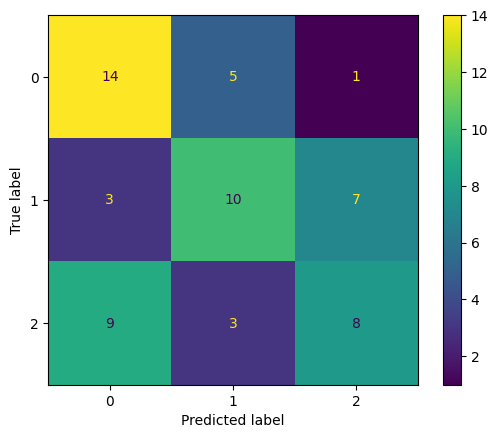

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def map_output_to_labels(arr: list, labels):
    # return [labels[el.index(1.0)] for el in arr]
    return [labels[el] for el in arr]
cm = confusion_matrix(map_output_to_labels(best_model_val_targets, labels), map_output_to_labels(best_model_val_preds.tolist(), labels), labels=labels)
print(cm)
# sns.heatmap(cm, yticklabels=labels, xticklabels=labels)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
augmented_train_df.to_csv('augmented_df2.csv')

In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

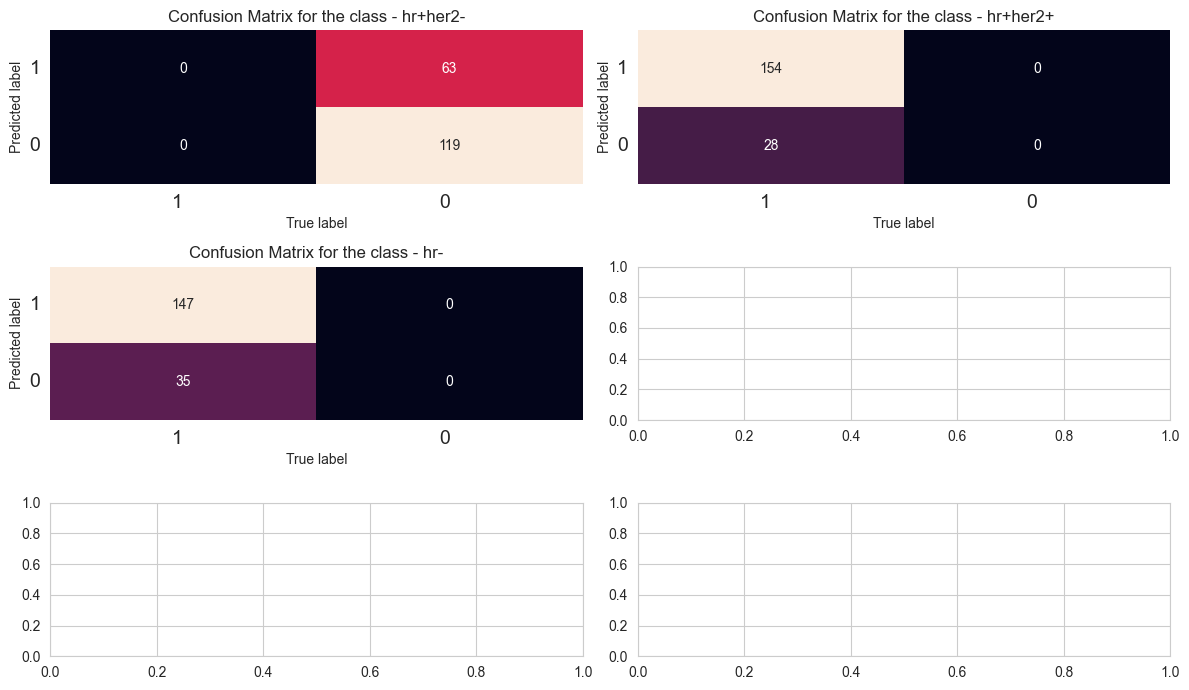

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["1", "0"])
    
fig.tight_layout()
plt.show()